# Fit PRDX1 koffs and kons

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Writes Barranco-Medina 2008 Fig. 1c PRDX1 injection parameters (filename: "ITC\_PRDX1\_inject\_params.csv")

Performs regression on ITC data digitized from Barranco-Medina et al. 2008 to fit the kon and koff of Prx decamer formation.

Writes fitted koff and kon (filename: "fitted\_koff\_kon\_PRDX1\_params.csv")

Performs regression on ITC data digitized from Barranco-Medina et al. 2008 to fit the kon and koff **and Kd** of Prx decamer formation.

Writes fitted koff and kon (filename: "fitted\_Kd\_koff\_kon\_PRDX1\_params.csv")

Performs identifyability analysis on the fits of kon and koff **and Kd**



**Requirements:**

Python libraries (see **Imports** below)

ITC Prx model (filename:"ITC_Prx_dim-dec.psc")

ITC model parameters (filename: "ITC_data_PRDX1_processed.csv")

**Note:**

The identifyability analysis is computationally intensive when performed in a Jupyter notebook. Therefore a script (filename:"script_identi_onestep_e5_koff_Kdapp_PRDX1.py") has been written to perform the identifyability analysis in python.

To perform the analysis of this notebook:
<ul>
<li>Run the notebook then</li>
<li>Run the identifyability script then</li>
<li>Run the notebook again</li>
</ul>

##### Imports

In [1]:
import os
import math
import copy
# from datetime import datetime
import gc

import dill as pickle
import scipy as sp
import numpy as np
# from sklearn.linear_model import LinearRegression
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc
from scipy.interpolate import interp1d

import pysces
from identifiability import conf_interval


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
INFO: libSBML not installed, SBML support not available.
You are using NumPy (1.23.5) with SciPy (1.10.1)
Assimulo CVode available
RateChar is available

No module named 'ipyparallel'
INFO: Parallel scanner not available

PySCeS environment
******************
pysces.model_dir = /home/jr/Pysces/psc
pysces.output_dir = /home/jr/Pysces


***********************************************************************
* Welcome to PySCeS (1.1.0) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2023  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with t

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

###### Fitting methods

In [4]:
fitting_method = "nelder"
# fitting_method = "leastsq"

## Barranco-Medina et al. 2008 PRDX1 

### data

In [5]:
df_PRDX1 = pd.read_csv(
    os.path.join(prev_dir,"ITC_data","ITC_data_PRDX1_processed.csv")).set_index('Time (sec)'
)

In [6]:
df_PRDX1

Rate μcal/sec
Time (sec)               
20              -0.016168
21              -0.016047
22              -0.015926
23              -0.015445
24              -0.014906
...                   ...
1991            -0.000800
1992            -0.000843
1993            -0.000910
1994            -0.001007
1995            -0.001104

[1760 rows x 1 columns]

### Inject params

In [7]:
# Values from Barranco-Medina 2008
inj_enthalpy_PRDX1 = 156
inj_volume_PRDX1 = 1.6 # ul
inj_mon_PRDX1 = 102 # uM MONOMERS
inj_dim_est_PRDX1 = 0.8
inj_dec_est_PRDX1 = (inj_mon_PRDX1/2 - 0.8)/5
inj_interval_PRDX1 = 200 # sec

ITC_exp_params = {"injection_Prx":inj_mon_PRDX1,
                "injection_volume":inj_volume_PRDX1,
                "injection_interval":inj_interval_PRDX1}

# PRDX1_inj_dim_est_PRDX1 = 0.8
# PRDX1_inj_dec_est = (PRDX1_inj_Prx/2 - 0.8)/5

In [8]:
# Set up df to update models
columns = ["Parameter","Value"]
df_ITC_PRDX1_inject_params = pd.DataFrame(columns = columns)

entry = {"Parameter": [ "injection_enthalpy",
                        "injection_volume",
                        "injection_Prx_mon",
                        "injection_dimer",
                        "injection_decamer",
                        "injection_interval",
                        "first_inject_ratio"],
         
       "Value":[inj_enthalpy_PRDX1,
                inj_volume_PRDX1,
                inj_mon_PRDX1,
                inj_dim_est_PRDX1, 
                inj_dec_est_PRDX1,
                inj_interval_PRDX1,
                1]}

entry = pd.DataFrame(entry)
df_ITC_PRDX1_inject_params = pd.concat([df_ITC_PRDX1_inject_params,entry])
df_ITC_PRDX1_inject_params.set_index("Parameter",inplace=True)

# # Adjust to values calculated from the figure (differs to text)
df_ITC_PRDX1_inject_params["Value"].loc["injection_dimer"] = df_ITC_PRDX1_inject_params["Value"].loc["injection_dimer"]
df_ITC_PRDX1_inject_params["Value"].loc["injection_decamer"] = df_ITC_PRDX1_inject_params["Value"].loc["injection_decamer"]

df_ITC_PRDX1_inject_params


Value
Parameter                 
injection_enthalpy  156.00
injection_volume      1.60
injection_Prx_mon   102.00
injection_dimer       0.80
injection_decamer    10.04
injection_interval  200.00
first_inject_ratio    1.00

In [9]:
# Write to file
df_ITC_PRDX1_inject_params.to_csv(os.path.join(os.getcwd(),"ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')
df_ITC_PRDX1_inject_params.to_csv(os.path.join(par_dir, "ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')


## Fits

In [10]:
def load_ITC_model(inj_params):
    # Load model
    mod_ITC_Prx_dim_dec = pysces.model("ITC_Prx_dim-dec.psc",dir = mod_dir)
    mod_ITC_Prx_dim_dec.mode_integrate_all_odes = True # As recommented by pysces
    mod_ITC_Prx_dim_dec.__settings__["cvode_access_solver"] = False
    mod_ITC_Prx_dim_dec.__settings__["cvode_return_event_timepoints"] = False
    mod_ITC_Prx_dim_dec.SetQuiet()

    # Note: exponent and Kd_app are set by the residual function
    
    # Set injection params
    for parameter in inj_params.index:
        value = inj_params.loc[parameter]["Value"]
        setattr(mod_ITC_Prx_dim_dec,parameter,value)
    
    return mod_ITC_Prx_dim_dec

def update_syringe_equis(mod_ITC_Prx_dim_dec):
    # Load syringe model
    mod_Prx_dec_onestep = pysces.model("Prx_dim-dec.psc", dir = mod_dir)
    mod_Prx_dec_onestep.mode_integrate_all_odes = True # As recommented by pysces
    mod_Prx_dec_onestep.SetQuiet()

    # Set exponent and Kd_app equal to ITC model
    mod_Prx_dec_onestep.exponent = mod_ITC_Prx_dim_dec.exponent
    mod_Prx_dec_onestep.Kd_app = mod_ITC_Prx_dim_dec.Kd_app
    
    # Set injection concentrations
    mod_Prx_dec_onestep.dimers_init = mod_ITC_Prx_dim_dec.injection_dimer
    mod_Prx_dec_onestep.decamers_init =  mod_ITC_Prx_dim_dec.injection_decamer

    mod_Prx_dec_onestep.doState()

    # Populate ITC model syringe with equilibrium values
    mod_ITC_Prx_dim_dec.injection_dimer = mod_Prx_dec_onestep.dimers_ss
    mod_ITC_Prx_dim_dec.injection_decamer = mod_Prx_dec_onestep.decamers_ss
    
    return mod_ITC_Prx_dim_dec


def scan_onestep_model(mod, association_enthalpy, end = 3600):
    
    # Scan model
    mod.doSim(points = end+1,end = end)
    data, lbls = mod.data_sim.getAllSimData(lbls = True)
    
    # Calculate enthalpy
    lbls[0] = 'Time (sec)'
    df_sim = pd.DataFrame(data, columns = lbls)
    df_sim['Time (sec)'] = np.rint(df_sim['Time (sec)']).astype(int)
    df_sim = df_sim.drop_duplicates(subset='Time (sec)', keep='last').set_index('Time (sec)')
    df_sim["Rate μcal/sec"] = (-df_sim["Disassociation"])*association_enthalpy*1/5*1/1000*60
#     df_sim = pd.DataFrame(df_sim['Rate μcal/sec'])
    
    # Baseline correction
    df_sim = baseline_correction(df_sim, mod)
    
    df_sim.drop(0,inplace=True) 

    # Normalise to AUC
    df_sim = normalise_to_AUC(df_sim,mod)
    
    return df_sim

def baseline_correction(df_sim, mod):
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 1
    end = mod.injection_interval

    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    next_baseline = df_temp[-10:-5]

    x2 = next_baseline.index.values.mean()
    y2 = next_baseline["Rate μcal/sec"].mean()

    x1 = 0.0
    y1 = next_baseline["Rate μcal/sec"].mean()

    baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

    current_baseline = next_baseline
    
    df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

    df_sim_baseline = pd.DataFrame(df_temp)

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval+1
        end = count*mod.injection_interval + mod.injection_interval

        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

        next_baseline = df_temp[-10:-5]

        x2 = next_baseline.index.values.mean()
        y2 = next_baseline["Rate μcal/sec"].mean()

        x1 = current_baseline.index.values.mean()
        y1 = current_baseline["Rate μcal/sec"].mean()

        baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

        df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

        current_baseline = next_baseline

        df_sim_baseline = pd.concat([df_sim_baseline,df_temp])

        count += 1

    df_sim["Rate μcal/sec no baseline corr."] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_baseline["Rate μcal/sec"].copy(deep=True)

    return df_sim

def normalise_to_AUC(df_sim,mod):
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 0
    end = mod.injection_interval
    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
    print(area)
    df_sim_AUCnorm = df_temp/area

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval
        end = start + mod.injection_interval
        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])
        area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
        print(f"Area: {area}")
        df_temp = df_temp/area
        df_sim_AUCnorm = pd.concat([df_sim_AUCnorm,df_temp])
        count += 1

    df_sim_AUCnorm = df_sim_AUCnorm.reset_index().drop_duplicates(
                                                            subset='Time (sec)',
                                                            keep='last'
                                                        ).set_index('Time (sec)').sort_index()

    df_sim["Rate μcal/sec baseline no AUC"] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_AUCnorm
    
    return df_sim

def fit_koff_kon_res(params, mod, enthalpy, df_data):
    """
    This is where the residuals which will be minimized are generated.
    Must contain the following:
    Update model params
    Scan model
    Calculate and return residuals
    """
    
    # Update model
    mod.koff = params['koff'].value
    mod.Kd_app = params['Kd_app'].value
    mod.exponent = params['exponent'].value
    mod.kon = mod.koff/mod.Kd_app
    
    # Store kon in params
    params['kon'].value = mod.kon
    
    # Update initial dimers and decamers per syringe equilibrium
    update_syringe_equis(mod)
    
    # Scan model
    df_sim = scan_onestep_model(mod, enthalpy)
    
    # Calculate residuals
    residuals = (
        df_data["Rate μcal/sec"].values - df_sim.loc[df_data.index]["Rate μcal/sec"].values
        )**2
    
    return residuals


### koff kon

#### Fit for publication

In [11]:
mod_ITC_Prx_dim_dec = load_ITC_model(df_ITC_PRDX1_inject_params)
exponent = 5
Kd_app = 1.1 # Villar
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
deprecation warning: event delay should be specified with keyword,
        see https://pyscesdocs.readthedocs.io/en/latest/inputfile_doc.html#events
deprecation warning: event delay should be specified with keyword,
        see https://pyscesdocs.readthedocs.io/en/latest/inputfile_doc.html#events
deprecation warning: event delay should be specified with keyword,
        see https://pyscesdocs.readthedocs.io/en/latest/inputfile_doc.html#events
deprecation warning: event delay should be specified with keyword,
        see https://pyscesdocs.readthedocs.io/en/latest/inputfile_doc.html#events
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation


In [12]:
# Set up lmfit parameter library object with each parameter to be fitted
param_lib = Parameters()
param_lib.add('koff',value=100.0,min=1e-12)
param_lib.add('kon',value=100.0,min=1e-12,vary=False)
param_lib.add('Kd_app', value = Kd_app,vary=False, min = 1e-12)
param_lib.add('exponent', value=exponent,vary=False, min = 5.0)

# Perform fit
fit_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method='nelder',
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1))

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_prot
executing first_injection_vol

event injection_prot is evaluating at 1.0
event injection_p


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_prot
executing first_injection_vol

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in

27.778908552514288
Area: 27.684733678335014
Area: 27.238407935452372
Area: 26.2695472812026
Area: 24.740053653431104
Area: 22.780197230901248
Area: 20.568627570190397
Area: 18.314843281065592
Area: 16.091134379453617
Area: 13.996438760603347
Area: 11.91849139400205
Area: 9.890081879720903
Area: 7.90078102237678
Area: 5.94107050982403
Area: 4.003098253024823
Area: 2.0806296930468133
Area: 0.1688153528014651
Area: 1.7361094737996234
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_

27.88038618617786
Area: 27.771688420999592
Area: 27.295830687212046
Area: 26.27950686600335
Area: 24.664141967746858
Area: 22.646834049702527
Area: 20.43023792206904
Area: 18.191595966936877
Area: 15.94882656814918
Area: 13.900881741256589
Area: 11.886110152288339
Area: 9.937667273620765
Area: 7.9259728976860755
Area: 6.036946651820285
Area: 4.1773989500884525
Area: 2.3390936142936685
Area: 0.6969880457852906
Area: 1.075589039218753
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_

27.848791251427144
Area: 27.7455242347178
Area: 27.27822781106894
Area: 26.280074194622834
Area: 24.687221106704893
Area: 22.662857468834197
Area: 20.43387440389936
Area: 18.222924563458456
Area: 15.977697241207453
Area: 13.916443135521657
Area: 11.795733196575853
Area: 9.792457887419832
Area: 7.836970388061121
Area: 5.917373909544924
Area: 4.023980307969363
Area: 2.1491547569045677
Area: 0.4672222838543503
Area: 1.3452375096628055
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol


27.845502072564273
Area: 27.74179354568347
Area: 27.274068388582613
Area: 26.267670829304603
Area: 24.675578611968223
Area: 22.67837268298241
Area: 20.475894746758694
Area: 18.241826217621202
Area: 16.057808628804015
Area: 13.87361381984283
Area: 11.89352656167459
Area: 9.917882399883833
Area: 7.876354730332033
Area: 5.951450471975075
Area: 4.052878002216676
Area: 2.172956175396122
Area: 0.4857085799622376
Area: 1.5316808493740426
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.840883105330132
Area: 27.73804287980062
Area: 27.27529546922037
Area: 26.281657069257626
Area: 24.711244294429758
Area: 22.714090946677018
Area: 20.47554941185314
Area: 18.21348672031459
Area: 16.0619205835195
Area: 13.876180902397557
Area: 11.


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

eve

event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 340


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_p

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_prot
executing first_injection_vol

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 401.0
event injec

27.84254716576989
Area: 27.739486681290163
Area: 27.273240139648014
Area: 26.26921064450493
Area: 24.679832262126716
Area: 22.68482044947436
Area: 20.44509377106351
Area: 18.184136721248972
Area: 15.972398425128201
Area: 13.909372717172312
Area: 11.785993449918857
Area: 9.878467810217105
Area: 7.836250016434195
Area: 5.90982572026786
Area: 4.153364986914499
Area: 2.308255826053858
Area: 0.2971776936569617
Area: 1.5662705558171668
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.84251848121256
Area: 27.739444576898578
Area: 27.273214494863396
Area: 26.269213629015375
Area: 24.69623143218856
Area: 22.66926313858633
Area: 20.48144720979365
Area: 18.247715465404873
Area: 16.06311368392014
Area: 13.9521619036391
Area: 11.8

27.842474897618274
Area: 27.73918165263138
Area: 27.27540094784512
Area: 26.280179902782347
Area: 24.70804144117641
Area: 22.70952326880514
Area: 20.508602553657166
Area: 18.2232249736002
Area: 16.07106801017143
Area: 13.959549989955475
Area: 11.832787845397286
Area: 9.822418119936358
Area: 7.859400869496075
Area: 5.931951633905823
Area: 4.174597908323779
Area: 2.3288229293967233
Area: 0.4970467255801183
Area: 1.3249982337725406
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.84259263988909
Area: 27.73950791918871
Area: 27.27621590904063
Area: 26.281625918021028
Area: 24.69372996516806
Area: 22.673693755862033
Area: 20.447367250330593
Area: 18.236783734396163
Area: 16.05296501219417
Area: 13.942796900400129
Area: 11.904023168773808
Area: 9.825596227834705
Area: 7.975934572578808
Area: 6.08198315735707
Area: 4.215034546074306
Area: 2.367918386708469
Area: 0.3554485078995169
Area: 1.3096165349188114
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been 

27.84242338127521
Area: 27.739838516577677
Area: 27.274053152841496
Area: 26.27874186511974
Area: 24.706092961731443
Area: 22.680501706420113
Area: 20.454271696898452
Area: 18.192879114974563
Area: 15.98051866072076
Area: 13.91685488623493
Area: 11.879903638349713
Area: 9.802893219726421
Area: 7.954498477203881
Area: 6.061504761289551
Area: 4.051228734578734
Area: 2.1673244955049724
Area: 0.29596086726596216
Area: 1.5674624209164691
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.842426478552824
Area: 27.739841172524585
Area: 27.277013362144306
Area: 26.283068347127937
Area: 24.712019351229415
Area: 22.714063555225835
Area: 20.513209363909926
Area: 18.27795137115183
Area: 16.028935007658603
Area: 13.961464445321809
Area: 11.921362334619904
Area: 9.841881842940952
Area: 7.877767134574637
Area: 5.949439839476346
Area: 4.1913166743047405
Area: 2.1837553075795526
Area: 0.31194818766210597
Area: 1.3519672167040553
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . 


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_p

27.84254114663383
Area: 27.739481743163307
Area: 27.273237749756
Area: 26.269212469025902
Area: 24.679839083574638
Area: 22.6579026555904
Area: 20.46998804166691
Area: 18.23679806975911
Area: 15.990545629108414
Area: 13.926088288672503
Area: 11.801580112811251
Area: 9.7931461152465
Area: 7.831691158451232
Area: 5.90547255066196
Area: 4.14918491194299
Area: 2.3042095311269866
Area: 0.2932199474249828
Area: 1.5701471245577405
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conse

27.8425598328573
Area: 27.73948002055001
Area: 27.27323667188328
Area: 26.269212522792593
Area: 24.679840558378736
Area: 22.657905438897803
Area: 20.43140242664691
Area: 18.171108440166506
Area: 16.022838000707708
Area: 13.914923827891391
Area: 11.878098100471846
Area: 9.801197135429408
Area: 7.839293163777679
Area: 5.912729392689527
Area: 4.011912330156931
Area: 2.290686392140236
Area: 0.4599264718646223
Area: 1.3612994545275954
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

In [13]:
from IPython.display import display

#### PySCeS 1.1.0

In [14]:
pysces.__version__

'1.1.0'

In [18]:
inits = [30, 50, 100, 200, 400]
fits = []
for i in inits:
    param_lib['koff'].value = i
    fit_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method='nelder',
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1))
    fits.append(fit_koff_kon)

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_p

26.592158344920108
Area: 26.74868526703403
Area: 26.225495781001666
Area: 25.140025676866028
Area: 23.398297934318226
Area: 21.251188129859933
Area: 18.948890860793615
Area: 16.663845107797073
Area: 14.736692752547278
Area: 12.98673049254241
Area: 11.454303742799526
Area: 10.103588374605206
Area: 8.739359287730641
Area: 7.623384217531847
Area: 6.7871476335818945
Area: 5.665679719964884
Area: 4.775853676923607
Area: 3.9338470364122817
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 

27.159257132342862
Area: 27.193337262893007
Area: 26.636419018129374
Area: 25.48770629410346
Area: 23.68458553292755
Area: 21.405781921578367
Area: 19.070833657701893
Area: 16.827280260560556
Area: 14.809698083651774
Area: 13.035545534014664
Area: 11.478685650945799
Area: 9.957180968995463
Area: 8.694221737506888
Area: 7.717809444005238
Area: 6.5030796610253905
Area: 5.714427909388481
Area: 4.601153989299642
Area: 3.9412243362155044
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.82816841774523
Area: 27.73756095237241
Area: 27.143284464379377
Area: 25.912760687183134
Area: 24.020478025312393
Area: 21.657976168441685
Area: 19.265245768756817
Area: 16.90492760005685
Area: 14.821256999033976
Area: 13.091953421800126
Area: 11.36961698700166
Area: 9.913830780773642
Area: 8.749934762778125
Area: 7.3997655720545445
Area: 6.273338882917503
Area: 5.40869251867973
Area: 4.429614832049365
Area: 3.2709567529356867
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.244485959903216
Area: 28.08451740192011
Area: 27.46796932668442
Area: 26.189009889457953
Area: 24.24371093396232
Area: 21.922198635478274
Area: 19.50339658127766
Area: 17.212588984734577
Area: 15.132613602508581
Area: 13.266589128441145
Area: 11.467608228611091
Area: 9.908497530275845
Area: 8.471081777206761
Area: 7.289346724542405
Area: 5.875887568352084
Area: 4.665339312699287
Area: 3.500855169352943
Area: 2.5903772062558597
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_prot
executing injection_

27.654125995308352
Area: 27.57783765107015
Area: 27.174179571987295
Area: 26.283973267159258
Area: 24.829461733695872
Area: 22.93207829045203
Area: 20.818066076088286
Area: 18.60456581971047
Area: 16.38478955673707
Area: 14.191183808891026
Area: 11.954476553857933
Area: 9.881188057863802
Area: 7.6721113427229275
Area: 5.547048895984512
Area: 3.4316741454510584
Area: 1.3212224129480035
Area: 0.6157297488196699
Area: 2.8748684399740796
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_

27.903091839508313
Area: 27.792110111664417
Area: 27.310540982832233
Area: 26.283598216651907
Area: 24.653861069209977
Area: 22.594927377490247
Area: 20.343036100510016
Area: 18.12742277495425
Area: 15.954641982605352
Area: 13.793084647559356
Area: 11.8535746873113
Area: 9.821223562689573
Area: 8.032774785312496
Area: 6.202196222260655
Area: 4.403508903850064
Area: 2.6286567601471127
Area: 0.6893214513203916
Area: 0.8940920035078486
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_

27.887414772163563
Area: 27.777713207402552
Area: 27.29961820243985
Area: 26.279384006216087
Area: 24.675957465186773
Area: 22.648728514781308
Area: 20.38950357984245
Area: 18.121879969013637
Area: 15.980953949505503
Area: 13.890237727226872
Area: 11.790725998393928
Area: 9.919879906600256
Area: 8.031561637082222
Area: 6.184002753559843
Area: 4.22080286013688
Area: 2.5535615007078216
Area: 0.5956294055273965
Area: 1.0085680205383605
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.867959412876107
Area: 27.761039476544557
Area: 27.286103095155386
Area: 26.267055212345408
Area: 24.659082455408118
Area: 22.620248882881143
Area: 20.4223765758553
Area: 18.186605023336565
Area: 15.944093161729137
Area: 13.816351192524127
Area: 11.85408085146085
Area: 9.79681971274998
Area: 7.859387623927113
Area: 6.089750903806419
Area: 4.253295071424467
Area: 2.275529904219657
Area: 0.4365776464473907
Area: 1.393148616771999
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.866005257779367
Area: 27.75937207970616
Area: 27.28808830782686
Area: 26.279759096167478
Area: 24.674595508476184
Area: 22.666328456381816
Area: 20.455620867426827
Area: 18.218545842337107
Area: 15.973795950782911
Area: 13.918877089586232
Area: 11.80669025451178
Area: 9.917188896067083
Area: 7.893868797208838
Area: 6.120221350037852
Area: 4.134851833073817
Area: 2.279102090161039
Area: 0.6181272639829332
Area: 1.1731279120706994
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

eve

27.863699246046384
Area: 27.75761831515471
Area: 27.28458801640185
Area: 26.2686507973007
Area: 24.664318704953036
Area: 22.656014243600268
Area: 20.406982714766894
Area: 18.143518945576883
Area: 15.99908506861194
Area: 13.899606712853815
Area: 11.87563842584342
Area: 9.813934143932354
Area: 7.871384409659139
Area: 6.096067001642317
Area: 4.1088039289264
Area: 2.4130445253276216
Area: 0.6078838306314196
Area: 1.3870479619464287
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c

27.863942476829394
Area: 27.758521904144292
Area: 27.289384318783192
Area: 26.284182735290123
Area: 24.69878539757468
Area: 22.687432054256117
Area: 20.438742704137027
Area: 18.224863624326332
Area: 15.979663066729819
Area: 13.923515588686756
Area: 11.897955002762744
Area: 9.936063847838208
Area: 8.024515940634185
Area: 6.151551393602046
Area: 4.1625063923756045
Area: 2.3029465999569836
Area: 0.6380344770041515
Area: 1.1568399191147989
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . n


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.863946176940313
Area: 27.75759913069408
Area: 27.283952217821273
Area: 26.26716446953606
Area: 24.678700213897844
Area: 22.664578279457924
Area: 20.454673812256047
Area: 18.166797887908633
Area: 15.957171352751581
Area: 13.902890045414734
Area: 11.790776532823527
Area: 9.900655134945952
Area: 7.876377999936284
Area: 6.1012214958633715
Area: 4.114185303495366
Area: 2.4187247793782074
Area: 0.4332533225205637
Area: 1.2016868983965474
Using model directory: /home/jr/Documents/papers/Decamerisa


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.864007160572758
Area: 27.757651616182294
Area: 27.28398575398214
Area: 26.267164494714194
Area: 24.678658701506233
Area: 22.637125463972964
Area: 20.40161556504662
Area: 18.13833585870457
Area: 15.930798594432874
Area: 13.87866555905437
Area: 1


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_

27.864022362477083
Area: 27.75836127477299
Area: 27.285651686257008
Area: 26.270108532096508
Area: 24.666007753577535
Area: 22.63028185624753
Area: 20.394701444534608
Area: 18.18317268129863
Area: 15.940864220754019
Area: 13.887916226436369
Area: 11.865049634937424
Area: 9.804307384953331
Area: 7.862718984340313
Area: 5.958770580690341
Area: 4.227821484689226
Area: 2.2459448491425964
Area: 0.5831395785012865
Area: 1.2101185616487367
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.864132500539103
Area: 27.757989685412486
Area: 27.28482044749275
Area: 26.27687583582077
Area: 24.688661500405566
Area: 22.64851962340926
Area: 20.4131202122267
Area: 18.200591877079
Area: 16.020505489780586
Area: 13.843892454071495
Area: 11.87715384491734
Area: 9.916756504128966
Area: 7.891678715861017
Area: 6.115829539693237
Area: 4.27355494063727
Area: 2.2902659579264464
Area: 0.6260331446617644
Area: 1.368654781730961
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_p

27.86412109912504
Area: 27.758675125082142
Area: 27.286469841176434
Area: 26.279802868755347
Area: 24.692670925851324
Area: 22.65309785542606
Area: 20.41775012964648
Area: 18.153661030821
Area: 15.94500098861025
Area: 13.891721695000207
Area: 11.868564819003343
Area: 9.80759336980313
Area: 7.980674557528448
Area: 6.110005425284185
Area: 4.122699178112393
Area: 2.2647209891199767
Area: 0.4205854228748709
Area: 1.2139073035098527
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_

27.864122823952293
Area: 27.757981163962064
Area: 27.287833257931656
Area: 26.281258785602848
Area: 24.678068841123476
Area: 22.643988950745637
Area: 20.447747181131188
Area: 18.16018134845796
Area: 15.951039874738
Area: 13.821580112678884
Area: 11.856531887824106
Area: 9.897458668157725
Area: 7.873389445993816
Area: 5.968908097583103
Area: 4.237504026886852
Area: 2.2553104432052513
Area: 0.5921855288470279
Area: 1.4018495514629825
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
28.237576168783463
Area: 28.079193346667516
Area: 27.463769605428546
Area: 26.197453942612764
Area: 24.24988074325213
Area: 21.888290410466894
Area: 19.490911542505025
Area: 17.199769981558067
Area: 15.032106839701619
Area: 13.241983941206676
Area


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_

Area: 6.9909677978384135
Area: 5.418887638317309
Area: 4.21071087011856
Area: 2.694557793900305
Area: 1.3713797168106985
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)


27.84449018204983
Area: 27.74183518133688
Area: 27.27591715199984
Area: 26.280153300763214
Area: 24.690353966843126
Area: 22.695702238478813
Area: 20.493861959364928
Area: 18.25914711924845
Area: 16.011416193999683
Area: 13.871432662056161
Area: 11.803832044048965
Area: 9.89674206644491
Area: 7.9689905481887235
Area: 5.949091568991876
Area: 4.049228534848956
Area: 2.167946922356464
Area: 0.4792245765345664
Area: 1.3396609167751357
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

27.639692506984424
Area: 27.5660217893212
Area: 27.167837384781226
Area: 26.2868444781075
Area: 24.85713254264605
Area: 22.966698590523265
Area: 20.8267786974705
Area: 18.631916744368063
Area: 16.356662908702443
Area: 14.12888320972481
Area: 12.005905562677835
Area: 9.864978952026897
Area: 7.745326017843528
Area: 5.641024315983408
Area: 3.5469524587144226
Area: 1.3074698613295497
Area: 0.649482930800724
Area: 2.9275488182420664
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c

executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0

27.89572105931131
Area: 27.785069802196052
Area: 27.304873528372454
Area: 26.280733311299265
Area: 24.672149864321632
Area: 22.611965514258983
Area: 20.36324186024962
Area: 18.09524402240535
Area: 15.957035203128095
Area: 13.793405173629331
Area: 11.759517523044762
Area: 9.794553432601072
Area: 7.883521741545872
Area: 6.144753044992822
Area: 4.192494967963235
Area: 2.537643504294515
Area: 0.5909263180819955
Area: 1.2023565590969665
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

eve

27.858921903280887
Area: 27.753505782435546
Area: 27.28201287511144
Area: 26.26877767686682
Area: 24.684426174737425
Area: 22.64662299031914
Area: 20.45239615915815
Area: 18.165811546613497
Area: 15.956059191787118
Area: 13.900070094868529
Area: 11.873414292542748
Area: 9.909238494092211
Area: 7.879918741252139
Area: 5.969402766180354
Area: 4.231304840728103
Area: 2.242813907485794
Area: 0.3920427147941119
Area: 1.2495078351704463
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol



event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.857982861092776
Area: 27.752489089739218
Area: 27.280755141303867
Area: 26.267327252220753
Area: 24.666408300264973
Area: 22.63406876122559
Area: 20.440080222231288
Area: 18.154241274631758
Area: 15.945298477706856
Area: 13.889890759707734
Area: 11.775678552458036
Area: 9.780821149930357
Area: 7.949408944618661
Area: 6.073632862539439
Area: 4.225750044741912
Area: 2.3984312338318476
Area: 0.5859922848423738
Area: 1.4162064434374504
Using model directory: /home/jr/Documents/papers/Decamerisa


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event i

27.857700482382015
Area: 27.752476425888204
Area: 27.281368672889773
Area: 26.26880948942006
Area: 24.6687179143673
Area: 22.664183471659374
Area: 20.417790726914774
Area: 18.15503764314629
Area: 16.00923979623652
Area: 13.831765943022573
Area: 11.862074874060514
Area: 9.796941130908051
Area: 7.849652038446879
Area: 5.939244769182501
Area: 4.20089513510533
Area: 2.2118359492558195
Area: 0.5408033134189238
Area: 1.461058201084445
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_p

27.85792119149031
Area: 27.753339289351246
Area: 27.283124769332378
Area: 26.271735114167655
Area: 24.68914326151
Area: 22.65256107169947
Area: 20.458752299419338
Area: 18.223141629502877
Area: 16.04109883022755
Area: 13.936591717668655
Area: 11.906745423747584
Area: 9.939665158257528
Area: 7.9078646085328295
Area: 6.123989253757308
Area: 4.273863414027478
Area: 2.444660687330698
Area: 0.45044045319440307
Area: 1.1942496251132924
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

27.858200683392706
Area: 27.753596443193544
Area: 27.283285207114066
Area: 26.271725997058056
Area: 24.672366139270164
Area: 22.668040816325806
Area: 20.42149237619864
Area: 18.209554724172786
Area: 16.02851465956173
Area: 13.849758708579143
Area: 11.879013394205066
Area: 9.913949183184778
Area: 7.9982090024867745
Area: 5.991147803697152
Area: 4.106289588394993
Area: 2.2411003802795553
Area: 0.5698732249109975
Area: 1.2315703525050994
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no

27.85793282342673
Area: 27.752446212135244
Area: 27.283735229235074
Area: 26.27990265601459
Area: 24.680474375668492
Area: 22.677290450817264
Area: 20.43094061923043
Area: 18.167463797959847
Area: 16.020746141825537
Area: 13.917848716682496
Area: 11.801681780928421
Area: 9.90588347243818
Area: 7.875998162531484
Area: 6.093900458575396
Area: 4.2451615384997865
Area: 2.4171202748458924
Area: 0.42377296134815823
Area: 1.2199453333457024
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 

27.85807576482871
Area: 27.75279810028845
Area: 27.281569985298354
Area: 26.268799545577135
Area: 24.685020212693317
Area: 22.67498798117193
Area: 20.467556427858337
Area: 18.18046512706518
Area: 16.032756636861325
Area: 13.853663945534624
Area: 11.794773468609591
Area: 9.899466226514813
Area: 7.9844224239085655
Area: 6.106967390711006
Area: 4.257725173050056
Area: 2.429292164562133
Area: 0.43568253189269246
Area: 1.4085152711016182
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.8581258024289
Area: 27.753532435376734
Area: 27.283245802182904
Area: 26.279909434356526
Area: 24.696949493277224
Area: 22.688500385066465
Area: 20.481188358334332
Area: 18.193471761876697
Area: 15.981682861314075
Area: 13.923368721993958
Area:

27.857995546508075
Area: 27.753193022688976
Area: 27.285413211233042
Area: 26.28281558100075
Area: 24.70093493919343
Area: 22.69303421876827
Area: 20.485775011517028
Area: 18.24878850743496
Area: 16.001889714845234
Area: 13.86670573123419
Area: 11.894635932254479
Area: 9.82781430480234
Area: 7.879202807472107
Area: 5.9678665535194
Area: 4.228827479012665
Area: 2.2394367947446234
Area: 0.5681256291761638
Area: 1.4337005629168302
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c

27.858097480870978
Area: 27.75350791800848
Area: 27.283229733714435
Area: 26.279908273788433
Area: 24.69696730753335
Area: 22.661375314159997
Area: 20.467545651249985
Area: 18.180452939046354
Area: 16.032747090097068
Area: 13.853660625611141
Area: 11.794782335604088
Area: 9.798709771045312
Area: 7.851709264379773
Area: 5.9416409551746145
Area: 4.058626638646881
Area: 2.19487906795149
Area: 0.3443251027505987
Area: 1.4977141811830976
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_p

27.85811334663764
Area: 27.75281246799181
Area: 27.28458135186451
Area: 26.27318848889995
Area: 24.690993945275736
Area: 22.654564273312744
Area: 20.421696390149258
Area: 18.15867025181417
Area: 15.949410015859156
Area: 13.893671567140833
Area: 11.779194218297322
Area: 9.884937948861609
Area: 7.856190090541275
Area: 6.075128532389988
Area: 4.227186697705602
Area: 2.2378195341707037
Area: 0.5665258556983785
Area: 1.2349896622455687
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

27.858091401580403
Area: 27.75350292696462
Area: 27.283227311036853
Area: 26.271730382321152
Area: 24.672448495606655
Area: 22.64093363530947
Area: 20.407926372646042
Area: 18.196738874849185
Area: 16.01662356679819
Area: 13.838706198029438
Area: 11.780904620332747
Area: 9.8865430586042
Area: 7.972226094841582
Area: 6.0953635804685335
Area: 4.101678516381554
Area: 2.23648720215243
Area: 0.384774054505318
Area: 1.2577937869820865
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

27.85797600054794
Area: 27.75317626130557
Area: 27.282403499740205
Area: 26.278450301305693
Area: 24.694975405230736
Area: 22.686276183207273
Area: 20.440039411665065
Area: 18.176103483431422
Area: 15.965578122936412
Area: 13.833185657545144
Area: 11.86363116031218
Area: 9.798681137795924
Area: 7.9662082799071685
Area: 6.089639333120137
Area: 4.241109438013055
Area: 2.4132713828433014
Area: 0.6003980743071509
Area: 1.4020959473526062
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_p

27.931085217802387
Area: 27.815145384550107
Area: 27.32315524928546
Area: 26.269943382109346
Area: 24.618986796976717
Area: 22.568756082600878
Area: 20.2900537213232
Area: 18.018330602963847
Area: 15.822211091292548
Area: 13.802279466708251
Area: 11.730913962482706
Area: 9.795055487971727
Area: 7.917765449879282
Area: 6.08502170215325
Area: 4.4345726189371915
Area: 2.5298386641088935
Area: 0.955152595250067
Area: 0.9536324975563504
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.855155112894007
Area: 27.750966585472504
Area: 27.28462549457637
Area: 26.276179481009038
Area: 24.680614332708274
Area: 22.651845465744163
Area: 20.459092677712324
Area: 18.17306136557763
Area: 16.025681311501227
Area: 13.921500266203141
Area: 11.803621281302005
Area: 9.804705439945119
Area: 7.854563962029122
Area: 6.070166446575326
Area: 4.218851439098804
Area: 2.2260540833382976
Area: 0.37052486773211935
Area: 1.47640317069729
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.86782008262434
Area: 27.761151890355105
Area: 27.28982732873789
Area: 26.281198086541867
Area: 24.675385344002308
Area: 22.666319535708094
Area: 20.45494105306975
Area: 18.217566485050458
Area: 16.0364141113955
Area: 13.859586099106018
Area: 11.893849555441909
Area: 9.833957153309287
Area: 7.894193745615446
Area: 5.992792974980878
Area: 4.119582997219148
Area: 2.4290884168316844
Area: 0.6291347433434027
Area: 1.3605487846778952
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_

Area: 4.268990108889377
Area: 2.282553911006142
Area: 0.4342456613384198
Area: 1.2046054848371979
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injecti

27.848694332839084
Area: 27.745198204569576
Area: 27.280383609192917
Area: 26.282966187012043
Area: 24.70757100198955
Area: 22.70562464218125
Area: 20.463610419444585
Area: 18.25109955267979
Area: 16.066591278269982
Area: 13.957330365604212
Area: 11.920969418685672
Area: 9.845931212838332
Area: 8.0013468974935
Area: 5.984475187178279
Area: 4.088453585001074
Area: 2.373019861764633
Area: 0.3685893564619793
Area: 1.4874652895539513
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

27.848791251427365
Area: 27.74483865276212
Area: 27.279567752288234
Area: 26.281519010369134
Area: 24.705588521563005
Area: 22.703370486789638
Area: 20.49992024325798
Area: 18.213508428693807
Area: 15.999925547427763
Area: 13.936919868097196
Area: 11.814821615232372
Area: 9.910526108852297
Area: 7.986089156683543
Area: 5.969878182140833
Area: 4.074426990694359
Area: 2.197953989955219
Area: 0.33441192816199194
Area: 1.320738752785851
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.845619834238853
Area: 27.742120557946798
Area: 27.27785933692852
Area: 26.273489643201366
Area: 24.68356166925851
Area: 22.687408839267494
Area: 20.485029904414205
Area: 18.199992018707377
Area: 16.049814797450672
Area: 13.94084254182322
Area: 11.903897317387338
Area: 9.827642153893283
Area: 7.867215975344397
Area: 6.071186210610174
Area: 4.20834968250254
Area: 2.2040777130091715
Area: 0.5158494101329008
Area: 1.302284282604531
Using model directory: /home/jr/Documents/papers/Decamerisation


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_prot
executing first_injection_vol

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in

27.851072993715608
Area: 27.7465505605782
Area: 27.27704224158833
Area: 26.267518804355504
Area: 24.68799232387581
Area: 22.655014943707762
Area: 20.46379472806815
Area: 18.178451031544885
Area: 15.967477008203945
Area: 13.832848346489065
Area: 11.771666180449774
Area: 9.872212107442456
Area: 7.952124522402003
Area: 6.068642051111006
Area: 4.067995706377432
Area: 2.194842867483339
Area: 0.5149177122578859
Area: 1.4954132548167234
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_p

27.850575437804608
Area: 27.746369228940367
Area: 27.277546811797144
Area: 26.2771403401235
Area: 24.698363576188402
Area: 22.66718084586198
Area: 20.476270129037758
Area: 18.241226609572017
Area: 15.994774598649823
Area: 13.857881976524471
Area: 11.881952244193378
Area: 9.910845386625612
Area: 7.988067996530383
Area: 6.1022609337078055
Area: 4.099712987291582
Area: 2.3862980171113417
Area: 0.5638872723612196
Area: 1.2483203318570337
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_

27.85035857044934
Area: 27.74664409301689
Area: 27.278313373955733
Area: 26.27045917574652
Area: 24.676016035028
Area: 22.649186760505184
Area: 20.45819502965366
Area: 18.22405439837289
Area: 16.0415611669368
Area: 13.934718771995332
Area: 11.81360651136505
Area: 9.910779908756147
Area: 7.873929146300991
Area: 5.954457402959673
Area: 4.061667903035452
Area: 2.187821471941699
Area: 0.3268937543654227
Area: 1.5257685797351832
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conse


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.850178816250324
Area: 27.7467144371328
Area: 27.28194815899141
Area: 26.284391429673814
Area: 24.70856677090466
Area: 22.679055246374098
Area: 20.449697293274966
Area: 18.186945856539204
Area: 16.0381217250414
Area: 13.931454589544792
Area: 11.897702079015067
Area: 9.825054466747845
Area: 7.8690851398567725
Area: 6.0782354666600265
Area: 4.220618258530585
Area: 2.3831797817725313
Area: 0.560300542539623
Area: 1.2523865529407907
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

27.850327659018728
Area: 27.746156848486894
Area: 27.2803966757324
Area: 26.281494357973784
Area: 24.704495556492187
Area: 22.674321230784745
Area: 20.444846615655514
Area: 18.182299838232638
Area: 16.033837047155757
Area: 13.927539002215491
Area: 11.80683663255808
Area: 9.804037269018544
Area: 7.849375543883057
Area: 5.9308884020017105
Area: 4.183475179406477
Area: 2.347477205703136
Area: 0.34567535144056727
Area: 1.3074879592199649
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.85020559958941
Area: 27.74649498712738
Area: 27.278219312989606
Area: 26.270461370752784
Area: 24.67614082224337
Area: 22.676517343472412
Area: 20.433412786469635
Area: 18.222219047558585
Area: 16.03985445788087
Area: 13.858192242380342
Area: 1


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

eve

27.850290492185703
Area: 27.74681151266276
Area: 27.279034415924386
Area: 26.27192372496431
Area: 24.69460452737172
Area: 22.663050388893986
Area: 20.47221953015925
Area: 18.186697587918648
Area: 16.03789649636004
Area: 13.93128122793418
Area: 11.810303586675982
Area: 9.807255716999308
Area: 7.852383705282722
Area: 6.062482688398469
Area: 4.205621878139164
Area: 2.2072199827381924
Area: 0.5256299415905565
Area: 1.4861156649593543
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event i


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.850161719752716
Area: 27.745787162074325
Area: 27.27955072225326
Area: 26.271915876579847
Area: 24.678151699648527
Area: 22.678804962499758
Area: 20.43574453203488
Area: 18.224433110549736
Area: 16.041907586524694
Area: 13.860091164124333
Area: 11.796468939222965
Area: 9.794297592132919
Area: 7.954207392825452
Area: 6.069670037550237
Area: 4.067968688115402
Area: 2.3553023264284567
Area: 0.35325788386676416
Area: 1.3001859487257694
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have

Area: 0.29671812454085966
Area: 1.355184042295626
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event inj


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_prot
executing injection_

27.850160171133073
Area: 27.746473739526653
Area: 27.281184763118702
Area: 26.28294031953983
Area: 24.706510273064318
Area: 22.67665042641511
Area: 20.447223228286457
Area: 18.184571102758703
Area: 16.035933734901825
Area: 13.8545569016274
Area: 11.791326554565549
Area: 9.889831585878627
Area: 7.8538925028334825
Area: 5.935130245335996
Area: 4.042855067161695
Area: 2.1693692979978367
Area: 0.48895022846548075
Area: 1.522105694345325
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.850182831682226
Area: 27.745787557248068
Area: 27.279550970574817
Area: 26.28004103597604
Area: 24.686128588956436
Area: 22.687833049712918
Area: 20.483620158664777
Area: 18.197586752567737
Area: 16.04796604060566
Area: 13.865717285671167
Area: 11.801692366425085
Area: 9.799197171656052
Area: 7.958826670672577
Area: 5.945335386844026
Area: 4.19723839651518
Area: 2.360723693166885
Area: 0.35854044027897847
Area: 1.2950478218735044
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

Area: 0.7407069642388096
Area: 2.250899057226651
Area: 5.345734920414132
Area: 8.47899254753408
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in

27.936062378686508
Area: 27.820152357920225
Area: 27.32756443622953
Area: 26.281589322552684
Area: 24.627815483132622
Area: 22.547030819056662
Area: 20.322580359514156
Area: 18.078411698446438
Area: 15.843998983092762
Area: 13.823822744181452
Area: 11.753298112597413
Area: 9.925029095531661
Area: 8.082520504719493
Area: 6.285697944783864
Area: 4.374595518227138
Area: 2.6027644588561443
Area: 1.0327906805150229
Area: 0.6681389334986829
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no

28.266966613747016
Area: 28.103009227406293
Area: 27.494697546870324
Area: 26.231073110891966
Area: 24.309660026172477
Area: 21.97509446629891
Area: 19.543258659062683
Area: 17.22570991495693
Area: 15.19130958947351
Area: 13.303575287131371
Area: 11.472877469591724
Area: 9.867972947838807
Area: 8.375910724925383
Area: 6.971936229723384
Area: 5.807802615522132
Area: 4.370224946547196
Area: 3.129540096149785
Area: 1.9219736943844417
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.835247862338747
Area: 27.733230587300866
Area: 27.269325656981522
Area: 26.277442450649975
Area: 24.70933796390733
Area: 22.714954180019276
Area: 20.516985345586004
Area: 18.282961308377466
Area: 16.033527546071316
Area: 13.889100848653197
Area

Area: 0.6961381316654847
Area: 1.0688967010457844
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event inj


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.84787193359218
Area: 27.74405089813231
Area: 27.27907310914318
Area: 26.273435266485663
Area: 24.698321828799113
Area: 22.695609684258457
Area: 20.49243319586937
Area: 18.2065578563032
Area: 15.993438211643305
Area: 13.855839500221373
Area: 11.878436814101741
Area: 9.905473438748125
Area: 7.866579952725879
Area: 6.073175686012218
Area: 4.068593749917087
Area: 2.352611301258123
Area: 0.3474703275452571
Area: 1.5094307703370333
Using model directory: /home/jr/Documents/papers/Decamerisation_c

27.847871758180514
Area: 27.7440505252821
Area: 27.276095833082774
Area: 26.269068447823884
Area: 24.692360851519705
Area: 22.68883837948637
Area: 20.446942153499343
Area: 18.184799366739448
Area: 16.03594905024392
Area: 13.92872470049298
Area: 11.893886398394349
Area: 9.919941561431193
Area: 7.880299638549632
Area: 6.086215237123093
Area: 4.081161610962009
Area: 2.364724891121529
Area: 0.5392178109273118
Area: 1.2762615687354124
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

27.86668945077479
Area: 27.760649752968394
Area: 27.287083999586574
Area: 26.2782882771164
Area: 24.672100015968084
Area: 22.663146948199316
Area: 20.412901898799287
Area: 18.199908774761365
Area: 16.020005250749556
Area: 13.919867441566307
Area: 11.896145590417298
Area: 9.93656475231369
Area: 7.9128076503503095
Area: 6.009396063526743
Area: 4.279665756092857
Area: 2.2995159921524237
Area: 0.6388535263297959
Area: 1.3524096955289533
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

27.857339628265112
Area: 27.752857846789308
Area: 27.282822375542565
Area: 26.271747358601765
Area: 24.68954342720994
Area: 22.653331438675664
Area: 20.420757962453564
Area: 18.209012640028746
Area: 16.02796825968051
Area: 13.84902643969328
Area: 11.877818618371197
Area: 9.811470694772243
Area: 7.863037095445125
Area: 6.080769088250335
Area: 4.231695290608269
Area: 2.2412515435245575
Area: 0.5687671758999848
Area: 1.434133275343095
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl

27.86207357605217
Area: 27.75622485210269
Area: 27.286729382822863
Area: 26.281295110165356
Area: 24.679560064694332
Area: 22.646815937850015
Area: 20.412242566608786
Area: 18.20012436354821
Area: 15.95661857654586
Area: 13.826105223762214
Area: 11.771406190246843
Area: 9.779880449803931
Area: 7.952536009710746
Area: 6.080956472094366
Area: 4.237582993174838
Area: 2.252838959586843
Area: 0.40618644759472256
Area: 1.4315275965026144
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.8601011881733
Area: 27.754534202168564
Area: 27.282656500986768
Area: 26.276954191916804
Area: 24.674980431231898
Area: 22.642700464754636
Area: 20.44799410832627
Area: 18.161337058432444
Area: 16.01524655910965
Area: 13.913407864743732
Area: 11.798574353465604
Area: 9.904668985666442
Area: 7.876666216308124
Area: 6.096905592402994
Area: 4.250520817018465
Area: 2.4249743092132543
Area: 0.4341242364646769
Area: 1.4071061219814887
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event i


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.86027930433593
Area: 27.7544571594821
Area: 27.28499968223358
Area: 26.27166674224267
Area: 24.687342829251925
Area: 22.67636606156549
Area: 20.46802884489057
Area: 18.231466730658333
Area: 15.985777033613841
Area: 13.852512572375424
Area: 11.882882768467292
Area: 9.919255034116874
Area: 8.00529869343526
Area: 6.12938520654133
Area: 4.137094328067793
Area: 2.273740931496498
Area: 0.6046470357056226
Area: 1.3947542043825338
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux con


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_p

27.860390251771364
Area: 27.75524657646948
Area: 27.28670538510522
Area: 26.274595004376767
Area: 24.691261195672872
Area: 22.653516111283018
Area: 20.458713840570137
Area: 18.171471383860837
Area: 15.961370539888618
Area: 13.905515956146319
Area: 11.879363196739163
Area: 9.916032892302159
Area: 8.002358163459018
Area: 6.126706286119172
Area: 4.279604337995137
Area: 2.2916418053148364
Area: 0.441740413074849
Area: 1.19878215741995
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.860526311117248
Area: 27.75559132886155
Area: 27.284535301004848
Area: 26.271668358263803
Area: 24.6706650280736
Area: 22.664877740568794
Area: 20.417305231346003
Area: 18.205184000296832
Area: 16.02458028839981
Area: 13.846723079660439
Area: 11.789677058260708
Area: 9.795789052285972
Area: 7.851255838107624
Area: 5.943872353944383
Area: 4.063727196530528
Area: 2.2030057473043647
Area: 0.355597367882025
Area: 1.2825044510260146
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.860523404658682
Area: 27.754896108194508
Area: 27.285892433071762
Area: 26.273131968674363
Area: 24.672673052051906
Area: 22.667149383521156
Area: 20.419611023053612
Area: 18.156179163449746
Area: 16.01052062923002
Area: 13.833698813203952
Area: 11.777592991647289
Area: 9.784480984562599
Area: 7.955299879737649
Area: 6.08189689875219
Area: 4.236617531540748
Area: 2.4120782217383576
Area: 0.6025743244603059
Area: 1.3966170374208953
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event i

27.86040317372631
Area: 27.755257432822344
Area: 27.283706004983358
Area: 26.270199448625757
Area: 24.668655968423245
Area: 22.662609779168246
Area: 20.415007866810875
Area: 18.20301033335993
Area: 16.022565286394013
Area: 13.844853405406967
Area: 11.787939425975537
Area: 9.895104567184926
Area: 7.867972777672226
Area: 5.959793848244056
Area: 4.079017884796617
Area: 2.217778754661028
Area: 0.36995229358651827
Area: 1.4691682033491786
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no 


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol

25.20309378693334
Area: 25.488778803472922
Area: 25.89485344020939
Area: 26.4203202053685
Area: 26.752690777048223
Area: 26.540502210274624
Area: 25.437747563957572
Area: 23.57647691092662
Area: 20.901125890522163
Area: 17.531658755846234
Area: 13.760092260327042
Area: 9.666312777617033
Area: 5.1215585482592205
Area: 0.42409758825268895
Area: 4.471507011548724
Area: 9.570641450041492
Area: 14.782884759146855
Area: 20.23095958242905
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl

26.15814688182015
Area: 26.30027313109349
Area: 26.386462263364812
Area: 26.35193227249218
Area: 25.980604250451204
Area: 25.081818993406163
Area: 23.585070287577416
Area: 21.514523723247628
Area: 19.032905933178828
Area: 16.15451107805366
Area: 12.989923373360854
Area: 9.599559990584632
Area: 6.058117818657362
Area: 2.3417549567071907
Area: 1.497372655002909
Area: 5.358934882739397
Area: 9.434750778198872
Area: 13.547951108442192
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_vol
executing injection_p

26.939886541878934
Area: 26.967100141511274
Area: 26.793777251636293
Area: 26.30373217521029
Area: 25.35972513206114
Area: 23.938688921103232
Area: 22.11116288822518
Area: 19.96312704636558
Area: 17.609486007882623
Area: 15.10105455026261
Area: 12.478383132452036
Area: 9.721973357522135
Area: 6.9657053687804655
Area: 4.052831518922053
Area: 1.121588964102346
Area: 1.738011515426944
Area: 4.701465246694857
Area: 7.871468859449024
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_p

28.135485290593127
Area: 27.990671684906296
Area: 27.433888481255327
Area: 26.26533828996476
Area: 24.46862620053113
Area: 22.287975370493754
Area: 19.96542276925915
Area: 17.636920910571156
Area: 15.553157333997431
Area: 13.483589020530063
Area: 11.606283462951499
Area: 9.956216981138521
Area: 8.30552271609431
Area: 6.721178116324977
Area: 5.188303928354265
Area: 3.6953061545005177
Area: 2.2332411164917882
Area: 0.7951733873623694
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_vol
27.737322960777263
Area: 27.649905802848973
Area: 27.21836629796721
Area: 26.274865739558482
Area: 24.761015594679012
Area: 22.832747927253234
Area: 20.67466873446133
Area: 18.405800086090892
Area: 16.173996256290124
Area: 13.989275954552435
Area:


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)
executing injection_prot
executing injection_


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event i

27.856772334735805
Area: 27.7521440748956
Area: 27.284753188686793
Area: 26.27467860890986
Area: 24.693850042922577
Area: 22.658496017934436
Area: 20.46511122505989
Area: 18.17840504554651
Area: 16.03075905006649
Area: 13.926736753912664
Area: 11.897039577465904
Area: 9.92980590529818
Area: 7.897631836018245
Area: 5.984076610588842
Area: 4.097914357616433
Area: 2.2312878277156774
Area: 0.5584748174967351
Area: 1.4448442224499862
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

27.86003813413908
Area: 27.755172801899196
Area: 27.28427373407629
Area: 26.2798753841153
Area: 24.679039844797362
Area: 22.647348508148042
Area: 20.413612183149848
Area: 18.201780606917414
Area: 16.021398938333768
Area: 13.919063014871107
Area: 11.891659003826327
Area: 9.927186980160943
Area: 8.012445519333854
Area: 6.135799219226455
Area: 4.1428634874925265
Area: 2.440816646900693
Area: 0.6298378232632782
Area: 1.1704323478877345
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl

27.86633403347774
Area: 27.759878093657736
Area: 27.28902617422133
Area: 26.27299320633158
Area: 24.668428911316305
Area: 22.63181846315445
Area: 20.39535668505003
Area: 18.18340735383371
Area: 15.941105449448777
Area: 13.813074389660564
Area: 11.850000975619267
Area: 9.791751897277937
Area: 7.852946679997141
Area: 6.081614099317561
Area: 4.09790889873859
Area: 2.4061736852522735
Area: 0.42399349708495593
Area: 1.4079717501550002
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_prot
executing injection_

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.864366422954024
Area: 27.758885336813417
Area: 27.28961248049937
Area: 26.275973060314303
Area: 24.67388625664467
Area: 22.66647003019227
Area: 20.41730143494369
Area: 18.153180199532656
Area: 16.008056082687368
Area: 13.832428874201645
Area: 11.866698269394101
Area: 9.907157114067836
Area: 7.997626399369741
Area: 5.996941825877399
Area: 4.119354738257883
Area: 2.26181917162089
Area: 0.5988424910089742
Area: 1.3949894182967402
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)
executing injection_vol
executing injection_p


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
executing injection_vol
executing injection_prot
27.864858284808875
Area: 27.75930725275183
Area: 27.289878174149514
Area: 26.275962152233205
Area: 24.673527968229095
Area: 22.66580239260029
Area: 20.45559541994899
Area: 18.218771530793024
Area: 16.037391028119682
Area: 13.935309561993513
Area: 11.909393918817958
Area: 9.947460468812038
Area: 8.036139639397344
Area: 6.163614600639276
Area: 4.175168591945485
Area: 2.3163801734324103
Area: 0.4718250159626267
Area: 1.3634002490861334
Using model directory: /home/jr/Documents/papers/Decamerisati

27.86480909871399
Area: 27.759265061245895
Area: 27.2898516047453
Area: 26.28416787952403
Area: 24.681585827139436
Area: 22.647607160885315
Area: 20.4119231757933
Area: 18.14798186495552
Area: 15.939764288985167
Area: 13.811380661170308
Area: 11.847518366191421
Area: 9.88955635564873
Area: 7.86651867962625
Area: 6.092718279752634
Area: 4.252194598170026
Area: 2.27039503809059
Area: 0.4270547604061521
Area: 1.20658289149583
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conser

27.864735319534613
Area: 27.75850617368982
Area: 27.288163451983113
Area: 26.28124843931453
Area: 24.677623869445924
Area: 22.67049832215697
Area: 20.421230228033043
Area: 18.208152247032526
Area: 15.964116073021817
Area: 13.833821611904849
Area: 11.780023604322768
Area: 9.78998118185137
Area: 7.964731899147485
Area: 5.965892873149965
Area: 4.235389867150312
Area: 2.4163897387543045
Area: 0.6125478372522095
Area: 1.1805757018028589
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)
executing injection_vol
executing injection_p

27.864621699402115
Area: 27.75818538488143
Area: 27.284319583333424
Area: 26.26714752301599
Area: 24.67820999203536
Area: 22.636265387286596
Area: 20.439742510735314
Area: 18.15240372629695
Area: 16.007365193190086
Area: 13.831886825929521
Area: 11.86642879516007
Area: 9.907195656904355
Area: 7.998024995393509
Area: 6.12720326753931
Area: 4.285202634489189
Area: 2.464510878784854
Area: 0.4787991538902612
Area: 1.3567575366509483
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)
executing injection_prot
executing injection_vol

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)
executing injection_vol
executing injection_prot


27.86463620150548
Area: 27.758190653482362
Area: 27.284322878414923
Area: 26.275395532369213
Area: 24.686210330781112
Area: 22.672720180381223
Area: 20.46261838638042
Area: 18.17421926764042
Area: 16.027503842572596
Area: 13.850543981081515
Area: 11.79552955610595
Area: 9.905662617650163
Area: 7.881732944826967
Area: 5.977549228636687
Area: 4.101214486166306
Area: 2.4071954769924755
Area: 0.4229165052529624
Area: 1.2106963436281073
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_p

27.864643886847617
Area: 27.7581972391927
Area: 27.287351472480847
Area: 26.2797850360407
Area: 24.69220473404236
Area: 22.652207007180873
Area: 20.41658772076373
Area: 18.2037604563171
Area: 16.023473860143778
Area: 13.922437785964394
Area: 11.809312297451367
Area: 9.81739130988586
Area: 7.990547902299809
Area: 5.99059163640783
Area: 4.113740172030719
Area: 2.2569079796215616
Area: 0.5946645975048575
Area: 1.3985411512563186
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux con

27.864750784094156
Area: 27.75922221042205
Area: 27.28681198602931
Area: 26.27978988731245
Area: 24.675602890292648
Area: 22.66820020696954
Area: 20.45805491825512
Area: 18.16986344319534
Area: 15.960038761044014
Area: 13.905767777202424
Area: 11.793802968827007
Area: 9.802883049215477
Area: 7.9768932942125295
Area: 6.107099869514267
Area: 4.1206348426475286
Area: 2.2635620928168927
Area: 0.420346379697893
Area: 1.2131784647085735
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

27.864759912599567
Area: 27.759222869681032
Area: 27.28681239918472
Area: 26.27978987370876
Area: 24.692212667082835
Area: 22.679526917005045
Area: 20.430375563733424
Area: 18.21680229230981
Area: 15.972165293520648
Area: 13.916905454400542
Area: 11.804171788657063
Area: 9.812577158906333
Area: 7.986016908023698
Area: 6.115793540849609
Area: 4.129004473099064
Area: 2.2716506503275204
Area: 0.42821318893618865
Area: 1.406125011610622
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)
executing first_injection_vol
executing first_injection_prot

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)
executing injection_vol
executing injection_prot

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event in

In [17]:
#leastsq
for f in fits:
    display(f)

In [19]:
#nelder
for f in fits:
    display(f)

#### PySCeS 1.0.3

In [14]:
pysces.__version__

'1.0.3'

In [17]:
inits = [30, 50, 100, 200, 400]
fits = []
for i in inits:
    param_lib['koff'].value = i
    fit_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method='nelder',
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1))
    fits.append(fit_koff_kon)

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is e

27.128421198064572
Area: 27.221983612316755
Area: 26.61655501708299
Area: 25.356177615866574
Area: 23.389909701274952
Area: 20.964757598719657
Area: 18.44062428239505
Area: 16.094018035955262
Area: 14.06047221143049
Area: 12.355918065915573
Area: 10.945169792593745
Area: 9.77823396647329
Area: 8.807179445693606
Area: 7.992136370419333
Area: 7.301501872488577
Area: 6.710725823360473
Area: 6.200801896557806
Area: 5.75696184997527
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
27.70311037585232
Area: 27.679464282417538
Area: 27.019025991252445
Area: 25.678062935835886
Area: 23.602476698538677
Area: 21.081406581982847
Area: 18.482863152713293
Area: 16.096058155914434
Area: 14.042275504330572
Area: 12.32939598574585
Area: 10.9158162902917
Area: 9.748016203382546
Area: 8.776854569452022
Area: 7.961953731155182
Area: 7.271539533203945
Area: 6.681006426070904
Area: 6.171328790492191
Area: 5.727726564016707
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialis

28.68348274815206
Area: 28.45867759095232
Area: 27.692653450222995
Area: 26.160099716286123
Area: 23.872938149561044
Area: 21.163039983578077
Area: 18.448943433430717
Area: 16.005044434549973
Area: 13.928502543358427
Area: 12.208429826218952
Area: 10.793341316318195
Area: 9.625892872475731
Area: 8.655625671025604
Area: 7.841759862668996
Area: 7.152411586386167
Area: 6.562938213338843
Area: 6.054312317457345
Area: 5.611748782757433
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (d


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (d


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.430960775666026
Area: 28.155121272649662
Area: 27.339748961928414
Area: 25.731795061094186
Area: 23.370307185271027
Area: 20.612110470476793
Area: 17.877619573237943
Area: 15.430454981572684
Area: 13.35731357925369
Area: 11.642755944218958
Area: 10.2337888701363
Area: 9.07263004330258
Area: 8.108686183252605
Area: 7.301118915830167
Area: 6.618010664538649
Area: 6.034705456407238
Area: 5.532158697356601
Area: 5.095587423529594
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialis

28.45083216151886
Area: 28.17499799613028
Area: 27.359628281973052
Area: 25.75165102341364
Area: 23.390093672223777
Area: 20.631772908090934
Area: 17.897113450084667
Area: 15.449748129692663
Area: 13.376384472001066
Area: 11.66159084163682
Area: 10.25238064161317
Area: 9.090975505109906
Area: 8.126784297199402
Area: 7.318971531858223
Area: 6.635618916718708
Area: 6.052071777748358
Area: 5.5492871167295705
Area: 5.112481220785684
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

28.44883675003221
Area: 28.17301088798218
Area: 27.357640763408273
Area: 25.749665365839995
Area: 23.388114685809683
Area: 20.62980615075616
Area: 17.895163460075427
Area: 15.447818121293334
Area: 13.37447660071741
Area: 11.659706462827012
Area: 10.25052046746832
Area: 9.089139861134965
Area: 8.12497328842836
Area: 7.317185012942417
Area: 6.633856726631745
Area: 6.0503336496867615
Area: 5.54757265316619
Area: 5.110790166622903
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux co

28.449838825013952
Area: 28.174004453611108
Area: 27.35863452756279
Area: 25.750658190842927
Area: 23.38910416842547
Area: 20.63078951520508
Area: 17.896138438529793
Area: 15.448783106383614
Area: 13.375430514592914
Area: 11.660648626138968
Area: 10.25145052015299
Area: 9.090058093324895
Area: 8.125879439888728
Area: 7.318078238192406
Area: 6.634737785158707
Area: 6.051202671926946
Area: 5.548429839966913
Area: 5.111635647881068
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.450326777727696
Area: 28.174501227775096
Area: 27.359131406022744
Area: 25.751154606194124
Area: 23.3895989176981
Area: 20.631281208134894
Area: 17.89662594019279
Area: 15.449265613274056
Area: 13.375907487887877
Area: 11.661119727128227
Area: 10.251915575006372
Area: 9.090516572050415
Area: 8.126331520052345
Area: 7.3185248741833
Area: 6.63517833941566
Area: 6.051637214355452
Area: 5.548858467284635
Area: 5.112058432244408
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_di


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.45058383005807
Area: 28.174749612645908
Area: 27.359379844323417
Area: 25.751402814567815
Area: 23.38984629429783
Area: 20.631527057221668
Area: 17.896869694098157
Area: 15.449506870285406


28.45027341322157
Area: 28.174439131370228
Area: 27.35906929635054
Area: 25.751092554163023
Area: 23.389537073746393
Area: 20.631219746124295
Area: 17.89656500202636
Area: 15.44920529939093
Area: 13.37584786562365
Area: 11.661060838442804
Area: 10.251857442879414
Area: 9.09045965222582
Area: 8.126275605330802
Area: 7.318469043557196
Area: 6.635123269223369
Area: 6.051582895289032
Area: 5.548804887623458
Area: 5.11200558902398
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux con


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.45019580858012
Area: 28.174361510647536
Area: 27.358991659200395
Area: 25.75101498917921
Area: 23.38945976892932
Area: 20.631142918774454
Area: 17.896488829518432
Area: 15.449129907251717
Area: 13.37577333803677
Area: 11.660987224443298
Area: 10.251784772973913
Area: 9.09038750140928
Area: 8.126204179563992
Area: 7.318399256668188
Area: 6.635054432197709
Area: 6.051514997275255
Area: 5.548737913617769
Area: 5.111939522733276
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d

28.450211329522137
Area: 28.17437703480071
Area: 27.359007186624677
Area: 25.75103050217469
Area: 23.38947522987888
Area: 20.631158284231418
Area: 17.896504064000272
Area: 15.449144985661162
Area: 13.375788243531222
Area: 11.661001946933741
Area: 10.251799300915406
Area: 9.090402307113314
Area: 8.126219033587256
Area: 7.318413213208438
Area: 6.635068198989686
Area: 6.05152857688528
Area: 5.548751308382926
Area: 5.111952721027893
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

28.450214239697743
Area: 28.174379945593493
Area: 27.359010098022228
Area: 25.751033410852056
Area: 23.389478128810126
Area: 20.63116116525513
Area: 17.896506920466006
Area: 15.449147812862094
Area: 13.375791038318381
Area: 11.661004711803015
Area: 10.251802035359251
Area: 9.090404528649737
Area: 8.126220981289636
Area: 7.318415832528806
Area: 6.635070782349591
Area: 6.051531123044935
Area: 5.548753819900554
Area: 5.111955203459175
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.45021326963966
Area: 28.174378975292367
Area: 27.35900912755793
Area: 25.75103244129992
Area: 23.389477162498263
Area: 20.63116020491422
Area: 17.896505968309064
Area: 15.449146870455573
Area: 13.375790106720368
Area: 11.66100379712061
Area: 10.251801138768204
Area: 9.090404067131624
Area: 8.126220765333482
Area: 7.3184149605054705
Area: 6.635069922647792
Area: 6.051530274253238
Area: 5.548752982698259
Area: 5.111954384789475
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialis

28.75468580427138
Area: 28.513317693009558
Area: 27.735608929346885
Area: 26.18202845753002
Area: 23.872611843483078
Area: 21.146063776223958
Area: 18.423169394054234
Area: 15.976202670053935
Area: 13.898885572448885
Area: 12.178809962256453
Area: 10.76393936029072
Area: 9.59675657886114
Area: 8.626764915190249
Area: 7.813172985965682
Area: 7.124096184921957
Area: 6.534892744793878
Area: 6.026530626466535
Area: 5.5842279224697275
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.81186897427851
Area: 28.554334138164883
Area: 27.76061141070047
Area: 26.183055756227525
Area: 23.849292072027183
Area: 21.10604450522275
Area: 18.37501719524379
Area: 15.925393388268553
Area: 13.84769381799275
Area: 12.127907860759864
Area: 10.713483433242745
Area: 9.546781822044588
Area: 8.577278501446484
Area: 7.764172391497364
Area: 7.075576687781502
Area: 6.486849888415129
Area: 5.978956182457852
Area: 5.537117713629104
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux c


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.8110239259468
Area: 28.54211446982938
Area: 27.735730309564737
Area: 26.140288659878777
Area: 23.78877425212409
Area: 21.034313374511214
Area: 18.29878667993478
Area: 15.848244033387369
Area: 13.770874617527168
Area: 12.051752276771754
Area: 10.638069409249084
Area: 9.472127919915321
Area: 8.50338700140346
Area: 7.691042017774997
Area: 7.003199284253305
Area: 6.415217816370313
Area: 5.90805794373339
Area: 5.466941989276963
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (d


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (d


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.439327559461375
Area: 28.163489203910007
Area: 27.348118366757838
Area: 25.740154367660985
Area: 23.37863585084204
Area: 20.620386799036655
Area: 17.88582470152302
Area: 15.438575376848469



event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.413158502156843
Area: 28.13731578697
Area: 27.321946177175167
Area: 25.71401741134582
Area: 23.35259478108562
Area: 20.594511127465502
Area: 17.86017281623214
Area: 15.413189621957896
Area: 13.340249057126965
Area: 11.625904612363128
Area: 10.217157515095714
Area: 9.056221086254489
Area: 8.092500618488286
Area: 7.285155467693194
Area: 6.602267867223805
Area: 6.019181122031493
Area: 5.516849453741954
Area: 5.0804896910902455
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.445867827520587
Area: 28.170032681499816
Area: 27.3546604810254
Area: 25.74668956020557
Area: 23.38514846365766
Area: 20.6268588242261
Area: 17.892241299137996
Area: 15.44492596984226
Area: 13.371617638748289
Area: 11.656882750636465
Area: 10.247733076203264
Area: 9.086389281920303
Area: 8.12225966687716
Area: 7.314508121637043
Area: 6.631216339381021
Area: 6.047729376617204
Area: 5.545003905497948
Area: 5.108256498273624
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised b


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.449946224935395
Area: 28.17412059425858
Area: 27.358750692260948
Area: 25.750774246878255
Area: 23.38921983465458
Area: 20.63090446673623
Area: 17.89625241008224
Area: 15.448895910109567
Area: 13.375542024491388
Area: 11.66075875837654
Area: 10.251559238789714
Area: 9.090165181775935
Area: 8.125984850028091
Area: 7.318182654161882
Area: 6.634840779110322
Area: 6.0513042612350105
Area: 5.5

28.450772308822955
Area: 28.17493813089997
Area: 27.359568403576834
Area: 25.751591200056268
Area: 23.39003404906662
Area: 20.631713652944967
Area: 17.89705469981343
Area: 15.44968998111811
Area: 13.376326990068636
Area: 11.661534061934058
Area: 10.252324586042615
Area: 9.090920749227077
Area: 8.126730512347507
Area: 7.318917702379739
Area: 6.635565820329128
Area: 6.052019407728519
Area: 5.5492354590677
Area: 5.112430287988327
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux co


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.450210371056812
Area: 28.17437607613143
Area: 27.359006227774046
Area: 25.751029544192914
Area: 23.389474275119667
Area: 20.63115733536762
Area: 17.896503123227053
Area: 15.449144054520604
Area: 13.375787323072998
Area: 11.661001045040411
Area: 10.251798416293465
Area: 9.090401488809189
Area: 8.126218220515877
Area: 7.318412351383539
Area: 6.635067348928379
Area: 6.051527738113986
Area: 5.54875048117681
Area: 5.111951928619051
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.450227195376144
Area: 28.174401624220447
Area: 27.359031781294856
Area: 25.75105507396328
Area: 23.389499719252154
Area: 20.631182622345463
Area: 17.896528194670477
Area: 15.449168869107519
Area: 13.37581185309813
Area: 11.661025267024701
Area: 10.25182231953008
Area: 9.090425041561923
Area: 8.126241464516005
Area: 7.318435319536962
Area: 6.635090004320619
Area: 6.051550086464374
Area: 5.548772525061406
Area: 5.111973654970847
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.450214424041086
Area: 28.174388850199378
Area: 27.3590190045347
Area: 25.751042309088078
Area: 23.389486997192602
Area: 20.631169978859592
Area: 17.896515658951124
Area: 15.449156461814919
Area: 13.375799588079868
Area: 11.661013165973088
Area: 10.251810384682008
Area: 9.090412983662013
Area: 8.126229329763394
Area: 7.318423836990224
Area: 6.635078677933139
Area: 6.0515389121845296
Area: 5.548761503105524
Area: 5.1119627950294895
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no f

28.45020803837219
Area: 28.17438246316717
Area: 27.359012616166765
Area: 25.751035926641805
Area: 23.38948063615839
Area: 20.631163657117387
Area: 17.896509391091275
Area: 15.44915025817112
Area: 13.375793455579933
Area: 11.661007094987387
Area: 10.251804388604663
Area: 9.090406857357317
Area: 8.126223275920223
Area: 7.318418092621489
Area: 6.63507301162598
Area: 6.051533325357872
Area: 5.54875599217534
Area: 5.111957357387886
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux co

28.450213563910303
Area: 28.174379269675345
Area: 27.359009421955186
Area: 25.75103273540731
Area: 23.389477455633788
Area: 20.631160496236816
Area: 17.896506257150897
Area: 15.449147156341498
Area: 13.375790389322617
Area: 11.661004076168567
Area: 10.25180140844785
Area: 9.090404375754991
Area: 8.12622107372382
Area: 7.318415224020066
Area: 6.635070182442696
Area: 6.051530531793892
Area: 5.548753236654397
Area: 5.111954635353118
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.450215160337503
Area: 28.174380866403915
Area: 27.359011019046775
Area: 25.751034331019042
Area: 23.38947904589124
Area: 20.631162076671682
Area: 17.89650782411651
Area: 15.449148707255352
Area: 13.37579192244569
Area: 11.661005578559662
Area: 10.251802884245457
Area: 9.090405848201968
Area: 8.126222527693923
Area: 7.3184166607557515
Area: 6.63507159961427
Area: 6.051531928521696
Area: 5.548754614422489
Area: 5.111955994236296
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot

28.44645253646411
Area: 28.17061749961899
Area: 27.35524539127655
Area: 25.747273885809985
Area: 23.38573079716558
Area: 20.62743754347186
Area: 17.892815073143645
Area: 15.445493826917623
Area: 13.372178995826252
Area: 11.65743719093859
Area: 10.248280381597475
Area: 9.086929705250753
Area: 8.122793083396228
Area: 7.315033711522577
Area: 6.631734757311556
Area: 6.048240694342192
Area: 5.545508243532235
Area: 5.108753945019753
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux co


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.44807161530861
Area: 28.172236889585058
Area: 27.356866619546008
Area: 25.74889196545387
Area: 23.387343898451217
Area: 20.62904013439182
Area: 17.894403979686242
Area: 15.447066429083735
A


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.45049137805071
Area: 28.17466586328501
Area: 27.35929607680141
Area: 25.751319124471845
Area: 23.3897628845532
Area: 20.63144416247126
Area: 17.896787505759324
Area: 15.449425523801454
Area


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (d

28.450247138920766
Area: 28.174412851560536
Area: 27.359043011034906
Area: 25.751066293255644
Area: 23.389510900917205
Area: 20.631193734951104
Area: 17.89653921255745
Area: 15.449179774120449
Area: 13.375822633061025
Area: 11.661035916378543
Area: 10.251832837760972
Area: 9.090435354868672
Area: 8.126251637808249
Area: 7.318445417367377
Area: 6.635099964580848
Area: 6.051559907416866
Area: 5.548782212450046
Area: 5.111983208688509
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no fl

28.450196546865406
Area: 28.17436224907154
Area: 27.358992397792086
Area: 25.751015727079952
Area: 23.38946050435729
Area: 20.631143649665766
Area: 17.896489554172874
Area: 15.449130624484965
Area: 13.375774047044631
Area: 11.660987939371303
Area: 10.251785479191327
Area: 9.090388176393013
Area: 8.126204852463907
Area: 7.318399919380439
Area: 6.63505508594091
Area: 6.051515643368393
Area: 5.5487385507878235
Area: 5.111940138640193
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.450221842901392
Area: 28.174387550381507
Area: 27.359017704419436
Area: 25.751041010165203
Area: 23.38948570263284
Area: 20.631168692297496
Area: 17.896514383354567
Area: 15.449155199287603
Area: 13.375798340035134
Area: 11.661011918377234
Area: 10.251809146756605
Area: 9.090411554075612
Area: 8.126227912305659
Area: 7.318422669412094
Area: 6.63507752608069
Area: 6.051537775138832
Area: 5


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d

28.45021472839379
Area: 28.17438043433671
Area: 27.359010586925777
Area: 25.751033899298864
Area: 23.389478615618852
Area: 20.631161649057763
Area: 17.896507400144767
Area: 15.449148287624276
Area: 13.375791507630996
Area: 11.661005170836445
Area: 10.251802487580592
Area: 9.090405473921466
Area: 8.126222152559224
Area: 7.318416269330063
Area: 6.635071213450975
Area: 6.051531550572127
Area: 5.548754241647048
Area: 5.111955621751727
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

27.457785195427352
Area: 27.182083170226214
Area: 26.367736671027817
Area: 24.7624452090662
Area: 22.406039021278367
Area: 19.655657790640166
Area: 16.931470144916055
Area: 14.496535135900748
Area: 12.436949339655325
Area: 10.736777470617076
Area: 9.342662306705895
Area: 8.196568340261818
Area: 7.247736229401286
Area: 6.455215461499675
Area: 5.787017180568623
Area: 5.218438843740526
Area: 4.730398982985651
Area: 4.308098010572397
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

27.558990531010522
Area: 27.2832573327431
Area: 26.468777446686722
Area: 24.86315209336854
Area: 22.506120248117114
Area: 19.75478273316679
Area: 17.029334960643272
Area: 14.592902727120219
Area: 12.53165612385594
Area: 10.82972129539643
Area: 9.43378570800323
Area: 8.285843353036466
Area: 7.335159704176313
Area: 6.54079548153352
Area: 5.8707709515118145
Area: 5.300391198921907
Area: 4.8105778307522495
Area: 4.386533575743126
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux con


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
27.864114123364267
Area: 27.588306235480495
Area: 26.773451462909584
Area: 25.166888581529726
Area: 22.808101294820567
Area: 20.05408262292529
Area: 17.325104115319554
Area: 14.88447921957253
Area: 12.818582743731335
Area: 11.111711937546662
Area: 9.710679548552882
Area: 8.55756685123813
Area: 7.601694727355511
Area: 6.802165467507684
Area: 6.127027835631067
Area: 5.551597680119258
Area: 5.056810633973684
Area: 4.6278803399415995
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initiali

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot

28.820074576910617
Area: 28.55492644167896
Area: 27.752877625529287
Area: 26.16390638372784
Area: 23.81837430159982
Area: 21.06756114464266
Area: 18.333351474680132
Area: 15.882980521373092
Area: 13.805391152683057
Area: 12.085953122165542
Area: 10.671931414691601
Area: 9.505643214424744
Area: 8.536555030630598
Area: 7.723862885243434
Area: 7.0356774728506375
Area: 6.447357075904768
Area: 5.939862193063621
Area: 5.498418015405561
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d

28.429119596863806
Area: 28.153288478375988
Area: 27.33791623182079
Area: 25.729964617239787
Area: 23.36848333810558
Area: 20.61029814700562
Area: 17.875822887586533
Area: 15.428676899088284
Area: 13.355556094461638
Area: 11.641020324367046
Area: 10.232075786548528
Area: 9.070939809056446
Area: 8.107018853833038
Area: 7.299474346925166
Area: 6.6163887274399125
Area: 6.033105936224236
Area: 5.530581241411156
Area: 5.094031674829559
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

28.480662685486816
Area: 28.204849113722243
Area: 27.38949117528623
Area: 25.781493731462433
Area: 23.419841406114866
Area: 20.661340403376535
Area: 17.92643141136827
Area: 15.478768106739546
Area: 13.405074320426541
Area: 11.68993065057086
Area: 10.280359745916394
Area: 9.118589794047466
Area: 8.15403163719853
Area: 7.34585091505138
Area: 6.6621353051076975
Area: 6.078229676665376
Area: 5.5750926599205455
Area: 5.137937981090371
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
28.448465466285572
Area: 28.172630818158026
Area: 27.357260621200844
Area: 25.74928558741522
Area: 23.387736189496717
Area: 20.62942999668391
Area: 17.89479051513208
Area: 15.447449000255265
Area: 13.374111716199781
Area: 11.659346078417782
Area: 10.250164717855878
Area: 9.08878923123641
Area: 8.124627614348478
Area: 7.316843352553751
Area: 6.6335197217698045
Area: 6.050001248943135
Area: 5.547244782287823
Area: 5.110466770480529
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initiali


event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event

28.448465466285572
Area: 28.172630818158026
Area: 27.357260621200844
Area: 25.74928558741522
Area: 23.387736189496717
Area: 20.62942999668391
Area: 17.89479051513208
Area: 15.447449000255265
Area: 13.374111716199781
Area: 11.659346078417782
Area: 10.250164717855878
Area: 9.08878923123641
Area: 8.124627614348478
Area: 7.316843352553751
Area: 6.6335197217698045
Area: 6.050001248943135
Area: 5.547244782287823
Area: 5.110466770480529
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.449270992184818
Area: 28.173436505261648
Area: 27.358066464095998
Area: 25.750090662104935
Area: 23.388538548642938
Area: 20.63022739185624
Area: 17.895581108235827
Area: 15.44823148810796
Area: 13.374885224258199
Area: 11.660110041043744
Area: 10.250918855174577
Area: 9.089533009462373
Area: 8.125361157703455
Area: 7.317567637421295
Area: 6.634234138656371
Area: 6.050705903283992
Area: 5.547939835988156
Area: 5.111152328764096
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

28.449673748323306
Area: 28.173839343180795
Area: 27.358469383204717
Area: 25.75049320134644
Area: 23.38893973344144
Area: 20.630626096439727
Area: 17.895976413026247
Area: 15.448622741264167
Area: 13.375271988940293
Area: 11.660492041290233
Area: 10.251295942052753
Area: 9.089905128379554
Area: 8.125728282789135
Area: 7.317929795595172
Area: 6.634591363947983
Area: 6.051058251097205
Area: 5.548287385282562
Area: 5.111495152299173
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

28.450479246762587
Area: 28.17464500767899
Area: 27.359275216639144
Area: 25.75129828358436
Area: 23.389742113505626
Area: 20.631423519676463
Area: 17.89676703888263
Area: 15.449405266583149
Area: 13.376045539863643
Area: 11.661256072476133
Area: 10.25205016863535
Area: 9.09064940168947
Area: 8.126462565343754
Area: 7.318654148597965
Area: 6.6353058540079255
Area: 6.051762987665957
Area: 5.548982528652977
Area: 5.1121808044754475
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.450076499859588
Area: 28.174242177286974
Area: 27.358872300737797
Area: 25.75089574183658
Area: 23.38934092173915
Area: 20.631024805729556
Area: 17.896371723258483
Area: 15.449014000785924
Area: 13.375658760803924
Area: 11.660874073940787
Area: 10.251673076576438
Area: 9.09027725400749
Area: 8.12609541835052
Area: 7.318291967046997
Area: 6.6349486034323935
Area: 6.051410612574803
Area: 5.548634949644173
Area: 5.11183796753108
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

Area: 9.090463747782145
Area: 8.12627964837423
Area: 7.318473054723058
Area: 6.635127225625312
Area: 6.0515867983653635
Area: 5.548808737326632
Area: 5.112009371034255
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is a

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_

28.4502149446316
Area: 28.174380650679733
Area: 27.359010803252563
Area: 25.75103411542419
Area: 23.389478831020917
Area: 20.631161863128085
Area: 17.896507612390007
Area: 15.449148497699722
Area: 13.375791715293714
Area: 11.661005375240586
Area: 10.251802687523229
Area: 9.090405623235366
Area: 8.126222303672476
Area: 7.3184164648869405
Area: 6.635071406456662
Area: 6.05153173985878
Area: 5.548754428284628
Area: 5.1119558026916305
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

28.45021730448101
Area: 28.174383011006107
Area: 27.35901316409278
Area: 25.751036474068652
Area: 23.38948118175046
Area: 20.631164199337253
Area: 17.896509928693003
Area: 15.449150790265607
Area: 13.375793981573274
Area: 11.661007617637818
Area: 10.251804899592699
Area: 9.090407799206712
Area: 8.126224454119923
Area: 7.318418588129235
Area: 6.635073500742635
Area: 6.051533804580948
Area: 5.5487564648599905
Area: 5.111957818102945
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_

25.496491870548347
Area: 25.221466504165736
Area: 24.41065345303817
Area: 22.814228720395658
Area: 20.474478824624263
Area: 17.749619811227205
Area: 15.05912626385257
Area: 12.664262221794093
Area: 10.649134729314047
Area: 8.996131590413096
Area: 7.650652342422819
Area: 6.5537840414748105
Area: 5.654165620428243
Area: 4.910446693794328
Area: 4.290348906568448
Area: 3.7689988262746428
Area: 3.327184547928192
Area: 2.950018706437965
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu


event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (del

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_

28.23931428442051
Area: 28.105816274587628
Area: 27.397761298667042
Area: 25.957119962436032
Area: 23.780258364441114
Area: 21.155996579206395
Area: 18.49393364161718
Area: 16.073631645630748
Area: 14.005075789625323
Area: 12.287021070566956
Area: 10.871968380651133
Area: 9.703992382092535
Area: 8.733057771607445
Area: 7.918491855778544
Area: 7.228443565635915
Area: 6.638282657218809
Area: 6.128975187374423
Area: 5.685736320451739
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flu

28.483220530358402
Area: 28.207402071705847
Area: 27.39204600927344
Area: 25.784049344164295
Area: 23.42238836338254
Area: 20.66387235001519
Area: 17.92894222801017
Area: 15.481253632054328
Area: 13.407531808657353
Area: 11.692358403342572
Area: 10.282756844521796
Area: 9.120954450595987
Area: 8.156364660870548
Area: 7.348154599355313
Area: 6.664408165893182
Area: 6.080472169007662
Area: 5.577305192778285
Area: 5.140120941777974
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d

28.380352842864678
Area: 28.104507502003347
Area: 27.289148997020327
Area: 25.681274745482657
Area: 23.319981262481353
Area: 20.56211021078029
Area: 17.828056701084556
Area: 15.38141169530639
Area: 13.308845521193318
Area: 11.594898414826051
Area: 10.186561105195848
Area: 9.026038337009835
Area: 8.06273490275706
Area: 7.255805428759038
Area: 6.57332936779756
Area: 5.9906493631522935
Area: 5.488718494121967
Area: 5.052753616762707
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d

28.450213045658096
Area: 28.174387471488266
Area: 27.359017625572783
Area: 25.751040931390204
Area: 23.38948562412031
Area: 20.63116861427585
Area: 17.89651430599654
Area: 15.449155122724372
Area: 13.37579826434809
Area: 11.66101183693786
Area: 10.251809064120819
Area: 9.090411482402939
Area: 8.126227840515131
Area: 7.318422596810576
Area: 6.635077454535723
Area: 6.0515377061684505
Area: 5.548760313520155
Area: 5.111961619234081
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

28.450217056078287
Area: 28.17438276249718
Area: 27.359012915583193
Area: 25.75103622579308
Area: 23.389480934306196
Area: 20.631163953423226
Area: 17.896509684871955
Area: 15.449150548941786
Area: 13.375793743014176
Area: 11.661007378293274
Area: 10.251804665887205
Area: 9.090407131785947
Area: 8.126223548675878
Area: 7.3184183649919
Area: 6.635073280412566
Area: 6.051533587147074
Area: 5.548756250450374
Area: 5.111957605376304
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux 

28.45021470207755
Area: 28.174380407991027
Area: 27.359010560590622
Area: 25.751033872999894
Area: 23.389478589400287
Area: 20.631161623001823
Area: 17.896507374310588
Area: 15.449148262058689
Area: 13.375791482356886
Area: 11.661005147169163
Area: 10.251802463708763
Area: 9.090405192916824
Area: 8.12622164175493
Area: 7.318416247780139
Area: 6.63507119204187
Area: 6.051531527564734
Area: 5.548754218911385
Area: 5.111955600934089
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

28.450206768359855
Area: 28.17438119282843
Area: 27.359011345599654
Area: 25.751034657266654
Area: 23.389479371045066
Area: 20.631162399818557
Area: 17.89650814450924
Area: 15.44914902435746
Area: 13.375792235916448
Area: 11.661005899694592
Area: 10.251803210183414
Area: 9.090405680501762
Area: 8.126222118417399
Area: 7.318416954071624
Area: 6.635071888621719
Area: 6.051532214039474
Area: 5.548754896110984
Area: 5.111956275221261
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux

In [18]:
# nelder
for f in fits:
    display(f)

In [16]:
# leastsq
for f in fits:
    display(f)

In [13]:
# Display fit report
fit_koff_kon

In [40]:
fit_koff_kon.params

Parameters([('koff', <Parameter 'koff', value=96.31387857096773, bounds=[1e-12:inf]>), ('kon', <Parameter 'kon', value=87.55807142815247 (fixed), bounds=[1e-12:inf]>), ('Kd_app', <Parameter 'Kd_app', value=1.1 (fixed), bounds=[1e-12:inf]>), ('exponent', <Parameter 'exponent', value=5 (fixed), bounds=[5.0:inf]>)])

In [20]:
# Simulate ITC with fitted parameters
df_sim = scan_onestep_model(mod_ITC_Prx_dim_dec,PRDX1_enthalpy)
residuals = (df_PRDX1["Rate μcal/sec"].values - df_sim.loc[df_PRDX1.index]["Rate μcal/sec"].values)**2


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_2200337/2432238154.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


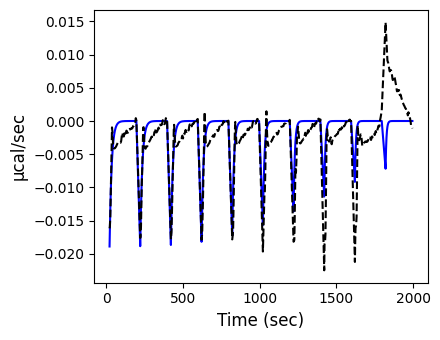

In [21]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].index, 
           df_sim.loc[df_PRDX1.index]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.index, df_PRDX1["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fit to Fig 1a top. Sum residual = {sum(residuals)}")
# axarr.legend()

f.tight_layout()
f.show()
f.savefig(f"{fig_dir}/Fit_one_step_e5_koff_heat_vs_time_PRDX1.pdf",dpi= mpl_dpi)

/tmp/ipykernel_2191235/3453044643.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


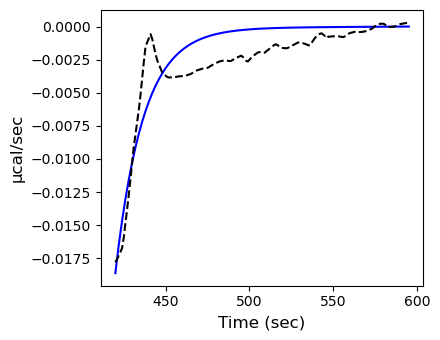

In [72]:
inject_num = 2
injection_interval = 200
# df_PRDX1.loc[(inject_num*180):(inject_num*180+180)].plot()

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].loc[start: end].index, 
           df_sim.loc[df_PRDX1.index].loc[start: end]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.loc[start: end].index, 
           df_PRDX1.loc[start: end]["Rate μcal/sec"],
           "k--", 
           label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fit to Fig 1a top. Sum residual = {sum(residuals)}")
# axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Fit_one_step_e5_koff_peak_heat_vs_time_PRDX1.pdf"),dpi= mpl_dpi)

#### Check fit data range dependancy

Check how koff and kon fit depends on data range

In [17]:
num_injections = 10
rates_fit = np.zeros((num_injections,3))

# Fit on each injection range
for count in range(num_injections):
    injection = count+1
    
    # Set up lmfit parameter library object with each parameter to be fitted
    param_lib = Parameters()
    param_lib.add('koff',value=500.0,min=1e-12)
    param_lib.add('kon',value=500.0,min=1e-12,vary=False)
    param_lib.add('Kd_app', value = Kd_app,vary=False, min = 1e-12)
    param_lib.add('exponent', value=exponent,vary=False, min = 5.0)

    # Slice data for injection range
    df_PRDX1_sliced = df_PRDX1[df_PRDX1.index <= injection*inj_interval_PRDX1 ]
    
    # Perform fit
    fit_koff_kon = minimize(fit_koff_kon_res, 
                             param_lib, 
                             method=fitting_method,
                             args=(mod_ITC_Prx_dim_dec,
                                   mod_ITC_Prx_dim_dec.injection_enthalpy,
                                   df_PRDX1_sliced),
                             epsfcn=0.0001)
    
    # Store koff and kon
    rates_fit[count,0] = injection
    rates_fit[count,1] = fit_koff_kon.params["koff"].value
    rates_fit[count,2] = fit_koff_kon.params["kon"].value

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0


29.833639807589233
Area: 34.83814611609911
Area: 34.02458941914981
Area: 32.421579357095546
Area: 30.070034725697223
Area: 27.327908872041252
Area: 24.615509435181206
Area: 22.19541093095698
Area: 20.152928553505546
Area: 18.47132730617372
Area: 17.09656403752716
Area: 15.97004630627358
Area: 15.040595574694256
Area: 14.266946288738692
Area: 13.616850766795109
Area: 13.065437642197466
Area: 12.593485899337185
Area: 12.186097079892606
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.83994460328899
Area: 34.89737881747662
Area: 34.08390170641004
Area: 32.48109468973968
Area: 30.129938114891168
Area: 27.388415941206084
Area: 24.67682258908663
Area: 22.257689276324374
Area: 20.216279903375046
Area: 18.535811712064636
Area: 17.162211681233497
Area: 16.03685863323765
Area: 15.108552542185706
Area: 14.336016350559872
Area: 13.686993374493886
Area: 13.136605411573964
Area: 12.665627337487608
Area: 12.259159326598219
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

30.333779105412024
Area: 38.5775714047337
Area: 37.770839892965036
Area: 36.18513247564591
Area: 33.86647779018053
Area: 31.175241919131185
Area: 28.530377340254915
Area: 26.19052471349493
Area: 24.236386280098664
Area: 22.647127345703495
Area: 21.36549842891908
Area: 20.330556125193613
Area: 19.48947484428965
Area: 18.7998485691513
Area: 18.228729243747573
Area: 17.75079701742891
Area: 17.346619393597315
Area: 17.0012409902296
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.535565247265076
Area: 30.45494579253261
Area: 29.638447403422248
Area: 28.02779755422223
Area: 25.66143752481736
Area: 22.895991582771185
Area: 20.152138711228847
Area: 17.69402725536813
Area: 15.60889559634803
Area: 13.88173467587597
Area: 12.459850668035605
Area: 11.285659020772073
Area: 10.30870017620962
Area: 9.488208289546337
Area: 8.792320000096712
Area: 8.196410339396147
Area: 7.681447504802641
Area: 7.232658252554522
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.53322629061495
Area: 30.36852212044689
Area: 29.55207053251859
Area: 27.941475547095365
Area: 25.575154954214383
Area: 22.809724744696414
Area: 20.065871129574433
Area: 17.60774702485425
Area: 15.522592220429681
Area: 13.795398257659055
Area: 12.373474920500069
Area: 11.19923949737568
Area: 10.22222999000287
Area: 9.401688265853275
Area: 8.70574749068604
Area: 8.109782427968323
Area: 7.594764875508102
Area: 7.145921253571215
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.533878543810467
Area: 30.392605915521
Area: 29.576135495737766
Area: 27.965520246398636
Area: 25.599183844024928
Area: 22.833746060667803
Area: 20.089889774518344
Area: 17.63176603082365
Area: 15.54661413078814
Area: 13.819425671146272
Area: 12.397509574534068
Area: 11.223281611057226
Area: 10.24628166369685
Area: 9.425750853989026
Area: 8.729821134103078
Area: 8.133867536242448
Area: 7.61886128919522
Area: 7.170029068931959
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.533729339916405
Area: 30.38708399835722
Area: 29.570617250902362
Area: 27.960006547794848
Area: 25.593673468146502
Area: 22.828237245332325
Area: 20.084381368072826
Area: 17.626257315596565
Area: 15.541104510004166
Area: 13.813914526402867
Area: 12.391996490837784
Area: 11.217766566051115
Area: 10.240764134684307
Area: 9.420230552139007
Area: 8.724298011557304
Area: 8.128341537123976
Area: 7.613332458761112
Area: 7.164497346737126
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.53410959385351
Area: 30.40034722424748
Area: 29.583873173349506
Area: 27.973252002416558
Area: 25.606911306925426
Area: 22.841471550023492
Area: 20.097614951045493
Area: 17.639491825946216
Area: 15.554341433572201
Area: 13.8271553384648
Area: 12.405242225430223
Area: 11.231019105210757
Area: 10.254022592272321
Area: 9.433494480252268
Area: 8.7375689556531
Area: 8.141619680199247
Area: 7.6266177152276855
Area: 7.177789760124467
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.534057515204896
Area: 30.399233434122984
Area: 29.582760049170574
Area: 27.97213969897651
Area: 25.605799595463086
Area: 22.840360101744206
Area: 20.096503542608442
Area: 17.638380307784445
Area: 15.553229681717983
Area: 13.826043227905771
Area: 12.404129675425205
Area: 11.229904397244221
Area: 10.25290763303899
Area: 9.432380281927898
Area: 8.736454135688637
Area: 8.140504220542919
Area:

29.53405043957149
Area: 30.39897129764549
Area: 29.582498070567524
Area: 27.971877915025885
Area: 25.605537952047122
Area: 22.840098520977723
Area: 20.09624197194771
Area: 17.638118712181292
Area: 15.55296803193116
Area: 13.825781502241467
Area: 12.403867847921353
Area: 11.229642417984655
Area: 10.252645535444126
Area: 9.43211806157649
Area: 8.736191770307192
Area: 8.140241704675697
Area: 7.625238968697878
Area: 7.176410211092605
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.53404921333459
Area: 30.398925868731812
Area: 29.58245266905238
Area: 27.971832547315703
Area: 25.605492608740352
Area: 22.840053188561
Area: 20.096196641310982
Area: 17.63807337724705
Area: 15.55292268763662
Area: 13.825736146672684
Area: 12.403822475398398
Area: 11.22959872678671
Area: 10.252601495913463
Area: 9.432072617303845
Area: 8.736146301116532
Area: 8.140196210445435
Area: 7.625193449205157
Area: 7.176364666385673
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
I


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

29.581507768131825
Area: 31.648016133661258
Area: 30.831693948929196
Area: 29.221572648638098
Area: 26.85633852211099
Area: 24.092773994007434
Area: 21.351567071431386
Area: 18.896758820731616
Area: 16.815432282321066
Area: 15.092426996828866
Area: 13.674929732689954
Area: 12.50525893917398
Area: 11.53288079016827
Area: 10.716986018676462
Area: 10.025670192241822
Area: 9.434284159425875
Area: 8.923772753429818
Area: 8.47934969579907
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Cal


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.543679893158433
Area: 30.729841540777514
Area: 29.913322161278
Area: 28.30266409310558
Area: 25.93634329110947
Area: 23.171005018672407
Area: 20.42733295285965
Area: 17.96947026991424
Area: 15.884643618352126
Area: 14.157831915902456
Area: 12.736329668579295
Area: 11.562540708852959
Area: 10.585997730187032
Area: 9.76593062344572
Area: 9.070469693251493
Area: 8.474986225100189
Area: 7.960


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0


29.833639807589233
Area: 34.83814611609911
Area: 34.02458941914981
Area: 32.421579357095546
Area: 30.070034725697223
Area: 27.327908872041252
Area: 24.615509435181206
Area: 22.19541093095698
Area: 20.152928553505546
Area: 18.47132730617372
Area: 17.09656403752716
Area: 15.97004630627358
Area: 15.040595574694256
Area: 14.266946288738692
Area: 13.616850766795109
Area: 13.065437642197466
Area: 12.593485899337185
Area: 12.186097079892606
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

29.56449828302952
Area: 31.283416778085886
Area: 30.466981654247412
Area: 28.8565603683553
Area: 26.490730445000548
Area: 23.726208171582854
Area: 20.98368599027926
Area: 18.527262532914396
Area: 16.444098557915144
Area: 14.719106103914376
Area: 13.299526283387546
Area: 12.127721599929764
Area: 11.153190566291249
Area: 10.33514572710268
Area: 9.641698300079442
Area: 9.048210163246038
Area: 8.535633866515608
Area: 8.089190872593308
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

29.537084224200882
Area: 30.508711629224795
Area: 29.692200371291385
Area: 28.081535808350164
Area: 25.715168763312633
Area: 22.94972696691729
Area: 20.20588853423129
Area: 17.747800675874792
Area: 15.66270110665845
Area: 13.935579238472354
Area: 12.513738890119452
Area: 11.3395958258981
Area: 10.36268849169772
Area: 9.542246918165922
Area: 8.84641005399693
Area: 8.250554559824533
Area: 7.735644928011466
Area: 7.286907884211525
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.52922632006259
Area: 30.23393814668299
Area: 29.41772784479594
Area: 27.80743690358157
Area: 25.441350261858705
Area: 22.67604157443435
Area: 19.93225191651879
Area: 17.47417289210816
Area: 15.389051966475334
Area: 13.661882064783287
Area: 12.23997483385554
Area: 11.065750665733988
Area: 10.088743146097743
Area: 9.268195942258515
Area: 8.572248881156186
Area: 7.97627709889933
Area: 7.461252052006884
Area: 7.012397848603218
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

29.53021897482766
Area: 30.26410641274536
Area: 29.44781293768359
Area: 27.837411655114387
Area: 25.471238673109752
Area: 22.705886519808285
Area: 19.962074114869495
Area: 17.503978017040808
Area: 15.418842079196303
Area: 13.691658510629576
Area: 12.269739526817245
Area: 11.095503479388062
Area: 10.118487211257584
Area: 9.297935115567991
Area: 8.601981270326664
Area: 8.006002162823922
Area: 7.490970872923785
Area: 7.0421116289243
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul


event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot

29.529891644594954
Area: 30.253899320568884
Area: 29.437631675101194
Area: 27.827262953144455
Area: 25.461115493486464
Area: 22.695775990262558
Area: 19.951970749543488
Area: 17.49387994264636
Area: 15.40874859044078
Area: 13.681569175356364
Area: 12.25965363892083
Area: 11.085423315538314
Area: 10.108409582208628
Area: 9.287856208618093
Area: 8.591904139807022
Area: 7.995927004350058
Area: 7.480897306414259
Area: 7.032039315916042
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

29.52989791210338
Area: 30.25389601636014
Area: 29.437628380185945
Area: 27.827259670183327
Area: 25.461112219760075
Area: 22.69577272133604
Area: 19.951967483044566
Area: 17.493876677936477
Area: 15.408745327297456
Area: 13.681565910029509
Area: 12.259650374879788
Area: 11.085419875095539
Area: 10.108406135469512
Area: 9.287852950513013
Area: 8.591900882355622
Area: 7.995923747598721
Area: 7.480894050449326
Area: 7.032036057903291
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

29.833639807589233
Area: 34.83814611609911
Area: 34.02458941914981
Area: 32.421579357095546
Area: 30.070034725697223
Area: 27.327908872041252
Area: 24.615509435181206
Area: 22.19541093095698
Area: 20.152928553505546
Area: 18.47132730617372
Area: 17.09656403752716
Area: 15.97004630627358
Area: 15.040595574694256
Area: 14.266946288738692
Area: 13.616850766795109
Area: 13.065437642197466
Area: 12.593485899337185
Area: 12.186097079892606
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.83994460328899
Area: 34.89737881747662
Area: 34.08390170641004
Area: 32.48109468973968
Area: 30.129938114891168
Area: 27.388415941206084
Area: 24.67682258908663
Area: 22.257689276324374
Area: 20.216279903375046
Area: 18.535811712064636
Area: 17.162211681233497
Area: 16.03685863323765
Area: 15.108552542185706
Area: 14.336016350559872
Area: 13.686993374493886
Area: 13.136605411573964
Area: 12.665627337487608
Area: 12.259159326598219
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

32.08172006598539
Area: 47.01598271994553
Area: 46.23610439854712
Area: 44.71719963316936
Area: 42.52354979687566
Area: 40.022303462080465
Area: 37.623483628338484
Area: 35.566133766404334
Area: 33.90911149107951
Area: 32.613159619165806
Area: 31.607962413463678
Area: 30.82457048164034
Area: 30.206114250344573
Area: 29.708948723662125
Area: 29.300689002738373
Area: 28.95772095409863
Area: 28.662892180956916
Area: 28.403815607637284
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc


event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.749823720128894
Area: 33.99324049568685
Area: 33.1786560348412
Area: 31.573019348520603
Area: 29.21644660250758
Area: 26.46648668512961
Area: 23.74361031188172
Area: 21.31094595075833
Area: 19.25446664791805
Area: 17.55801958384618
Area: 16.168017424284304
Area: 15.026207671983638
Area: 14.081645665882792
Area: 13.293238009768261
Area: 12.628857719231375
Area: 12.063720761768138
Area: 11.


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.592388221659714
Area: 31.856040464544655
Area: 31.039802452037883
Area: 29.429902574215102
Area: 27.065102682076102
Area: 24.302230207760378
Area: 21.561967699004857
Area: 19.10831229792373
Area: 17.028291352742635
Area: 15.30669432210981
Area: 13.890666047540417
Area: 12.722495947699224
Area: 11.751631110206963
Area: 10.937243209855858
Area: 10.247416967554523
Area: 9.657496850700447
Area: 9.148422419016589
Area: 8.705400177166966
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-d

29.566491887922464
Area: 31.329257319365162
Area: 30.512833934266684
Area: 28.90244419891387
Area: 26.536677458326384
Area: 23.772257488465293
Area: 21.029876636755873
Area: 18.573627563782214
Area: 16.490662681779327
Area: 14.765886285949318
Area: 13.346533109544758
Area: 12.174961612138329
Area: 11.200666152552959
Area: 10.38285516050564
Area: 9.689642139170438
Area: 9.096384809848434
Area: 8.584035424404801
Area: 8.137815493950217
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.539165915770067
Area: 30.581839987671994
Area: 29.76532062267173
Area: 28.154649556790915
Area: 25.788286153011796
Area: 23.0228638367655
Area: 20.279061640536924
Area: 17.821025580517095
Area: 15.735991286761445
Area: 14.00894526457157
Area: 12.587188819692425
Area: 11.413134942670663
Area: 10.436321584249242
Area: 9.615975295174712
Area: 8.920231986312945
Area: 8.324473213868673
Area: 7.809659546222564
Area: 7.361015926720666
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.52835121754933
Area: 30.210194765162008
Area: 29.39407980577364
Area: 27.783902695965807
Area: 25.417903705192437
Area: 22.65264140880119
Area: 19.90887452132776
Area: 17.4508116795522
Area: 15.36570556502693
Area: 13.638549509346083
Area: 12.216654799677045
Area: 11.042440795119017
Area: 10.065443499219251
Area: 9.244906453899867
Area: 8.548968101774568
Area: 7.953004996549106
Area: 7.437988055207003
Area: 6.989141835325076
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc



event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.527555005596806
Area: 30.190483999819065
Area: 29.37445693915927
Area: 27.764402176202857
Area: 25.39849872211993
Area: 22.633285672529738
Area: 19.889541478608447
Area: 17.431494121526814



event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay

Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot

44.300067117810805
Area: 82.15398032921243
Area: 81.58342506246733
Area: 80.53700675305596
Area: 79.1454988738217
Area: 77.71947917378064
Area: 76.50061332921554
Area: 75.54654188678684
Area: 74.80166060159333
Area: 74.18952148129368
Area: 73.65273700011873
Area: 73.15703694825494
Area: 72.68435904737692
Area: 72.22593959021603
Area: 71.77773758737945
Area: 71.33805630111615
Area: 70.90611881299769
Area: 70.48162734572267
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L 

29.797163939939107
Area: 34.484935549015866
Area: 33.67092460208575
Area: 32.06675476719254
Area: 29.71299179449202
Area: 26.96741282635928
Area: 24.250399327413763
Area: 21.8247716887828
Area: 19.776136961461145
Area: 18.088018416189488
Area: 16.706573868266624
Area: 15.573364705659174
Area: 14.63731309876549
Area: 13.85723160070534
Area: 13.200924505520891
Area: 12.64356191014664
Area: 12.165944342196644
Area: 11.753190682398856
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

29.550482343241246
Area: 30.929067030284024
Area: 30.112565225237148
Area: 28.501961233261568
Area: 26.135758335263848
Area: 23.37062341361015
Area: 20.627245817401807
Area: 18.169758125089754
Area: 16.085370696656238
Area: 14.359044040612085
Area: 12.938058726667268
Area: 11.764806441846698
Area: 10.78880666101566
Area: 9.969289314230227
Area: 9.274380927973125
Area: 8.679444434059807
Area: 8.165443129300847
Area: 7.71760214056987
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

29.541154563049755
Area: 30.648764779040366
Area: 29.832243353044458
Area: 28.221574707774685
Area: 25.855225203997644
Area: 23.08983375265789
Area: 20.34608117041037
Area: 17.888112138539405
Area: 15.803159263977209
Area: 14.076205861575678
Area: 12.654550936389983
Area: 11.480602305665363
Area: 10.503896808234508
Area: 9.683662748704132
Area: 8.98803376770489
Area: 8.392385574011795
Area: 7.877682476191141
Area: 7.429145385694653
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

29.522170777888125
Area: 30.097163376773615
Area: 29.281968382709003
Area: 27.672985652537673
Area: 25.30792277000447
Area: 22.543144684720655
Area: 19.79958341565161
Area: 17.34163983766644
Area: 15.256639257214678
Area: 13.529584064657156
Area: 12.107785370124656
Area: 10.933663169834608
Area: 9.956753540058278
Area: 9.136301389714946
Area: 8.440444677332222
Area: 7.844559273760521
Area: 7.329616717919305
Area: 6.880844279375588
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

29.51714029319252
Area: 30.045970946572847
Area: 29.23163065056419
Area: 27.623784734969114
Area: 25.25970200050776
Area: 22.495442025520095
Area: 19.752072559430772
Area: 17.294216064755886
Area: 15.209281458842133
Area: 13.482289142604836
Area: 12.060552653897027
Area: 10.886491763328094
Area: 9.909640753469965
Area: 9.08924557533017
Area: 8.39344396866166
Area: 7.797612674915814
Area: 7.282721981497357
Area: 6.833998950155106
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

29.519506861803684
Area: 30.067365046732316
Area: 29.25260853170405
Area: 27.644210691315806
Area: 25.279668915702153
Area: 22.515154842237482
Area: 19.771692292863634
Area: 17.31379590078035
Area: 15.228832722312916
Area: 13.50181251844533
Area: 12.08004873363162
Area: 10.905961429514575
Area: 9.929084556630773
Area: 9.10866442355773
Area: 8.412838706324681
Area: 7.8169838027982905
Area: 7.302069986032953
Area: 6.853325376455409
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

29.518566608802686
Area: 30.058256003837837
Area: 29.243670659795075
Area: 27.63553844320397
Area: 25.271185803451214
Area: 22.50675922277771
Area: 19.76333675041598
Area: 17.30545600200197
Area: 15.220504907808186
Area: 13.493496170565706
Area: 12.0717437395554
Area: 10.897667463767641
Area: 9.920801407382223
Area: 9.100391589784174
Area: 8.404575945106856
Area: 7.808730837094088
Area: 7.293826564662126
Area: 6.84509089744925
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (d

/tmp/ipykernel_35459/3533420310.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


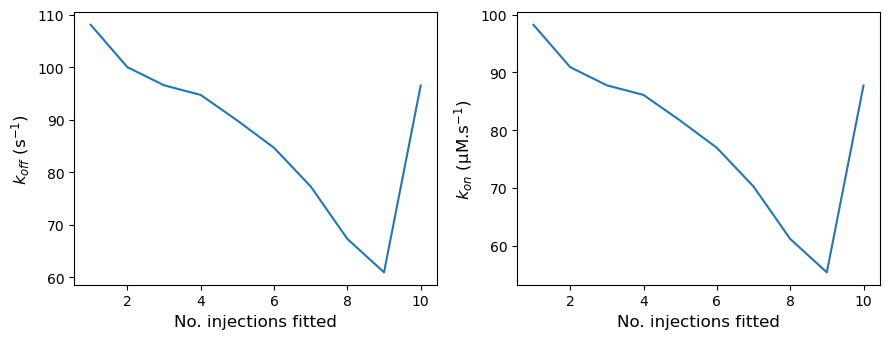

In [18]:
# Plot results

rows = 1
cols =2

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

ax = axarr.flat[0]
ax.plot(rates_fit[:,0], rates_fit[:,1])
ax.set_xlabel(f'No. injections fitted',fontsize = mpl_xlabel_fontsize)
ax.set_ylabel(f'$k_{{off}}$ (s$^{{-1}}$)',fontsize = mpl_ylabel_fontsize)

ax = axarr.flat[1]
ax.plot(rates_fit[:,0], rates_fit[:,2])
ax.set_xlabel(f'No. injections fitted',fontsize = mpl_xlabel_fontsize)
ax.set_ylabel(f'$k_{{on}}$ ({mu}M.s$^{{-1}}$)',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()


### Kd, koff and kon

In [19]:
mod_ITC_Prx_dim_dec = load_ITC_model(df_ITC_PRDX1_inject_params)
exponent = 5
Kd_app = 1.1 # Villar
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation
Info: "injection_volume" has been initialised but does not occur in a rate equation
Info: "injection_dimer" has been initialised but does not occur in a rate equation
Info: "injection_decamer" has been initialised but does not occur in a rate equation
Info: "injection_interval" has been initialised but does not occur in a rate equation
Info: "first_inject_ratio" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conserv

In [20]:
# Set up lmfit parameter library object with each parameter to be fitted
param_lib = Parameters()
param_lib.add('koff',value=500.0,min=1e-12)
param_lib.add('kon',value=500.0,min=1e-12,vary=False)
param_lib.add('Kd_app', value = Kd_app, min = 1e-12)
param_lib.add('exponent', value=exponent,vary=False, min = 5.0)

# Perform fit
fit_Kd_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method=fitting_method,
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1),
                         epsfcn=0.0001)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0


29.833639807589233
Area: 34.83814611609911
Area: 34.02458941914981
Area: 32.421579357095546
Area: 30.070034725697223
Area: 27.327908872041252
Area: 24.615509435181206
Area: 22.19541093095698
Area: 20.152928553505546
Area: 18.47132730617372
Area: 17.09656403752716
Area: 15.97004630627358
Area: 15.040595574694256
Area: 14.266946288738692
Area: 13.616850766795109
Area: 13.065437642197466
Area: 12.593485899337185
Area: 12.186097079892606
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.83994460328899
Area: 34.89737881747662
Area: 34.08390170641004
Area: 32.48109468973968
Area: 30.129938114891168
Area: 27.388415941206084
Area: 24.67682258908663
Area: 22.257689276324374
Area: 20.216279903375046
Area: 18.535811712064636
Area: 17.162211681233497
Area: 16.03685863323765
Area: 15.108552542185706
Area: 14.336016350559872
Area: 13.686993374493886
Area: 13.136605411573964
Area: 12.665627337487608
Area: 12.259159326598219
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

32.738664733676636
Area: 49.684238878157764
Area: 49.67818366779711
Area: 49.66433674534008
Area: 49.63790010724928
Area: 49.59305860877848
Area: 49.52315276280373
Area: 49.420935642488494
Area: 49.27893741612205
Area: 49.08993682199591
Area: 48.84752465543991
Area: 48.546713481762694
Area: 48.18452268157128
Area: 47.76044583375427
Area: 47.276719279058135
Area: 46.73831999737041
Area: 46.15268159119671
Area: 45.529155377584964
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat


event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.60284612614794
Area: 31.33924579333333
Area: 31.3123853504764
Area: 31.2507580826149
Area: 31.133457267161724
Area: 30.936571768349854
Area: 30.6355960169657
Area: 30.208785609207503
Area: 29.641030750111824
Area: 28.927352862077132
Area: 28.07489792414368
Area: 27.102601429633907
Area: 26.03845282020525
Area: 24.915201636073824
Area: 23.765800153725937
Area: 22.61973925912853
Area: 21.500865579647407
Area: 20.42665515562482
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc


29.60286157113393
Area: 31.339347414907458
Area: 31.31275907662435
Area: 31.251752759299148
Area: 31.13562114158269
Area: 30.940661107392827
Area: 30.642540302235304
Area: 30.2195979271421
Area: 29.656666880914493
Area: 28.94854483276284
Area: 28.102011787982438
Area: 27.135555380936633
Area: 26.07673668366227
Area: 24.957971758452143
Area: 23.812022849605157
Area: 22.668336667188317
Area: 21.550829148768322
Area: 20.47711271771526
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

29.577228578599595
Area: 31.162296784728365
Area: 30.712299947271656
Area: 29.761993946217178
Area: 28.207010338036415
Area: 26.13158459901744
Area: 23.778577010011386
Area: 21.416020963926343
Area: 19.229844554407116
Area: 17.303865759529444
Area: 15.65069604912581
Area: 14.247478890783134
Area: 13.059165406810829
Area: 12.05012157798881
Area: 11.188720544731723
Area: 10.448492039117177
Area: 9.807892863128004
Area: 9.24957898238326
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.601475466733802
Area: 31.319781461707276
Area: 31.27798056764707
Area: 31.182363154261267
Area: 31.001451014250108
Area: 30.70091016606068
Area: 30.248756842207538
Area: 29.621926451388006
Area: 28.812546825270566
Area: 27.831571830431265
Area: 26.70793406830717
Area: 25.483249309315642
Area: 24.204041867376084
Area: 22.914306305019533
Area: 21.650422288034786
Area: 20.43899793969613
Area: 19.297071257251606
Area: 18.233672406874035
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 


29.58616428521679
Area: 31.212741041638388
Area: 30.914897335151
Area: 30.26724120230571
Area: 29.15265096402722
Area: 27.557165763160622
Area: 25.596611984597885
Area: 23.46595464845069
Area: 21.35408805927096
Area: 19.38929217580751
Area: 17.632710349963112
Area: 16.097429755554437
Area: 14.770310606109414
Area: 13.627333239414718
Area: 12.642173613554315
Area: 11.790158486736608
Area: 11.049762678611325
Area: 10.402852786146337
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

29.586376601718875
Area: 31.21411978902676
Area: 30.919796979535306
Area: 30.279359203527477
Area: 29.17585220083084
Area: 27.593457155011645
Area: 25.64485105888274
Area: 23.52250124009202
Area: 21.414612687151727
Area: 19.450218289350907
Area: 17.691695265079336
Area: 16.153219272094784
Area: 14.822403778969788
Area: 13.675669376379695
Area: 12.686921019525936
Area: 11.831602007369273
Area: 11.088207421160478
Area: 10.438612963515116
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 


29.585568129996737
Area: 31.122712069966248
Area: 30.883313143388396
Area: 30.35677438242804
Area: 29.4318891979073
Area: 28.067551772704046
Area: 26.327578586707414
Area: 24.36041986147243
Area: 22.33688298923844
Area: 20.393752538769554
Area: 18.612291490778816
Area: 17.025277588923437
Area: 15.634035753646604
Area: 14.423627779629761
Area: 13.372776678768235
Area: 12.459311159173325
Area: 11.66269740491033
Area: 10.964977825731664
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Ca

29.576451232716394
Area: 30.877234117302027
Area: 30.614818907447894
Area: 30.040242070022163
Area: 29.03913536993655
Area: 27.58005334977694
Area: 25.747123506712303
Area: 23.708354115681
Area: 21.643461901722894
Area: 19.68702676905749
Area: 17.91258381885004
Area: 16.3447739361039
Area: 14.978697483016415
Area: 13.795380493022948
Area: 12.771234780890909
Area: 11.88289046916166
Area: 11.109317810661594
Area: 10.432422873632857
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

29.576634244021264
Area: 30.87842399744559
Area: 30.61906650413778
Area: 30.05084574427571
Area: 29.059749272688336
Area: 27.612964866982747
Area: 25.791900371256368
Area: 23.762054794437088
Area: 21.7021052345521
Area: 19.74702201829794
Area: 17.971390040805815
Area: 16.4009086673747
Area: 15.031455738750568
Area: 13.844561674184375
Area: 12.816911871456075
Area: 11.925287603166968
Area: 11.148708393001916
Area: 10.46909203941753
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

29.572982820385395
Area: 30.837944916239156
Area: 30.528103336232032
Area: 29.85591128915942
Area: 28.703824734410865
Area: 27.06436746281329
Area: 25.0640288164241
Area: 22.905976657818943
Area: 20.781106269226772
Area: 18.814986748121612
Area: 17.064576505224295
Area: 15.53936380259447
Area: 14.223784107781322
Area: 13.092401766399533
Area: 12.118159934439975
Area: 11.276077715423034
Area: 10.54454875147373
Area: 9.905445105642858
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Cal


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.573205287206505
Area: 30.839388837410713
Area: 30.53322684344095
Area: 29.8685434686058
Area: 28.727888805992727
Area: 27.10175659550397
Area: 25.11336089084077
Area: 22.963394355041014
Area: 20.84218873384038
Area: 18.87618056955805
Area: 17.12360489531049
Area: 15.595054468362454
Area: 14.275689546039478
Area: 13.140503627969792
Area: 12.162656516651328
Area: 11.317264598109304
Area: 10.582741703519007
Area: 9.940967630273517
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [C


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.56570723270489
Area: 30.72558593614081
Area: 30.335080523329083
Area: 29.500961344798856
Area: 28.109497015090042
Area: 26.203176791280892
Area: 23.978003274938327
Area: 21.68108862484714
A


event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (d


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

29.474729952632256
Area: 29.835444743812584
Area: 28.327295669047274
Area: 25.693434574438438
Area: 22.414990079972714
Area: 19.18370339486583
Area: 16.399036734035263
Area: 14.142878814865167
Area: 12.350488958807853
Area: 10.924944943791477
Area: 9.7796225445107
Area: 8.84703259398948
Area: 8.076996081241019
Area: 7.432613346102569
Area: 6.8866686767554555
Area: 6.418891891012244
Area: 6.014019289643059
Area: 5.6603826110910695
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

29.47636577572898
Area: 29.845463743554227
Area: 28.3577031738326
Area: 25.750359232253142
Area: 22.49075057829483
Area: 19.265061982961576
Area: 16.476895684883946
Area: 14.213531052128364
Area: 12.413332226939675
Area: 10.980624536812012
Area: 9.8291277649169
Area: 8.891345654554259
Area: 8.11696067967941
Area: 7.468924743619511
Area: 6.919900549155356
Area: 6.449509179394282
Area: 6.042399466336559
Area: 5.686836041737329
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating

29.510760032534908
Area: 30.062770134417956
Area: 29.02639705583575
Area: 27.06111358934935
Area: 24.334153445668417
Area: 21.341813951487957
Area: 18.533761177548055
Area: 16.12180398746594
Area: 14.13378514019528
Area: 12.517279078404952
Area: 11.201748017715184
Area: 10.1229340520473
Area: 9.228955172778381
Area: 8.479798456818292
Area: 7.84503317584084
Area: 7.301581951919082
Area: 6.831814964457358
Area: 6.422160344003085
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

29.4751499140567
Area: 29.816076991700903
Area: 28.338208922573436
Area: 25.743662078846125
Area: 22.493140274525675
Area: 19.270248982669656
Area: 16.480562186359215
Area: 14.213913303135103
Area: 12.41012532183968
Area: 10.974124368546006
Area: 9.819788571740919
Area: 8.879621104935422
Area: 8.103245127251212
Area: 7.453547797939811
Area: 6.903131859967367
Area: 6.431564790149704
Area: 6.023456847729011
Area: 5.667041818992995
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

29.497374669077992
Area: 29.977524573362672
Area: 28.7587419298375
Area: 26.520858276292994
Area: 23.549538101200206
Area: 20.43359225905788
Area: 17.616888135969877
Area: 15.260785802256935
Area: 13.351844191878978
Area: 11.815941986590543
Area: 10.573846510287863
Area: 9.5589099936396
Area: 8.719494159277014
Area: 8.01668089698701
Area: 7.421325101804868
Area: 6.9115272398569605
Area: 6.47065065034791
Area: 6.085963675578312
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

29.48598090767871
Area: 29.874596939407365
Area: 28.54803383983189
Area: 26.157341653390198
Area: 23.0607520645212
Area: 19.891890655368265
Area: 17.082213698782066
Area: 14.762786561126626
Area: 12.899035653466907
Area: 11.40688250839734
Area: 10.20360857903178
Area: 9.221949942017012
Area: 8.410694653950124
Area: 7.73167473837963
Area: 7.156480157818373
Area: 6.663854908283548
Area: 6.237717595204343
Area: 5.865755642240634
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculatin

29.48735707031996
Area: 29.883117945420793
Area: 28.57453963903321
Area: 26.208872562306613
Area: 23.132190081864792
Area: 19.971227559640216
Area: 17.15990988921133
Area: 14.83430729443824
Area: 12.963185764750513
Area: 11.464001907375827
Area: 10.25452784852618
Area: 9.267576812197873
Area: 8.451854889974125
Area: 7.76906043992372
Area: 7.190683887131616
Area: 6.695344882564441
Area: 6.266884854481913
Area: 5.892917907454744
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

29.481384843083553
Area: 29.844889682035006
Area: 28.46118021843487
Area: 25.992100570349443
Area: 22.83456321936759
Area: 19.64278152834893
Area: 16.8394561962672
Area: 14.539850130241613
Area: 12.699201693647963
Area: 11.228923851877541
Area: 10.04482571193273
Area: 9.079481215253539
Area: 8.281965535879186
Area: 7.61450869882045
Area: 7.049094921546216
Area: 6.564800544251802
Area: 6.145798253898269
Area: 5.7799877256253795
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

29.49148497471484
Area: 29.92049621958689
Area: 28.647771472885484
Area: 26.33263459888961
Area: 23.296925907731886
Area: 20.15283801632914
Area: 17.33874464299176
Area: 15.000803992757609
Area: 13.114694277325606
Area: 11.601074620949287
Area: 10.378829230708162
Area: 9.380950653058866
Area: 8.555990176120131
Area: 7.865396115541274
Area: 7.280410674279577
Area: 6.7794413362656245
Area: 6.346150796194276
Area: 5.968010522317244
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

29.49280509212472
Area: 29.92858442236844
Area: 28.673093800425658
Area: 26.38245789632009
Area: 23.36689583879893
Area: 20.23139960298829
Area: 17.416281725679134
Area: 15.072535862018757
Area: 13.179229973046525
Area: 11.658629344985103
Area: 10.430180825174578
Area: 9.426987820573801
Area: 8.597527801022576
Area: 7.9031369613525735
Area: 7.31492818695089
Area: 6.811221003482874
Area: 6.37557913636939
Area: 5.995414382430535
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculati

29.481589389078078
Area: 29.84499772770378
Area: 28.46600881060446
Area: 26.003325705322098
Area: 22.85067168977636
Area: 19.660655016275186
Area: 16.856753530145383
Area: 14.555519535390253
Area: 12.713001484316656
Area: 11.24096387239694
Area: 10.055330757643373
Area: 9.08867800130601
Area: 8.290074614929265
Area: 7.621698063285293
Area: 7.055509010129153
Area: 6.570549532683169
Area: 6.1509783645308245
Area: 5.78468791415467
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat


event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.48702860805208
Area: 29.886645615782722
Area: 28.564576756957162
Area: 26.180218467797047
Area: 23.088682214035884
Area: 19.92180856540977
Area: 17.11166948178866
Area: 14.790618739242458
A

29.488400972338287
Area: 29.89513017866708
Area: 28.590983471138923
Area: 26.23160195802989
Area: 23.15999719735873
Area: 20.001081990254146
Area: 17.18935412844596
Area: 14.862157590493386
Area: 12.989124410476334
Area: 11.488103939185194
Area: 10.277008135996756
Area: 9.288667995316798
Area: 8.471772573003435
Area: 7.787993562976066
Area: 7.2087736398890065
Area: 6.712715285086423
Area: 6.283638201141731
Area: 5.909135854621753
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

29.484620064675042
Area: 29.87099586286404
Area: 28.51878209113993
Area: 26.092792680845115
Area: 22.968510755914256
Area: 19.78899680676996
Area: 16.981929090920445
Area: 14.671288519974418
Area: 12.817879288097226
Area: 11.33555691920558
Area: 10.14091290085053
Area: 9.16660964314433
Area: 8.361548501256452
Area: 7.6877414834551425
Area: 7.116959748745746
Area: 6.62808636731708
Area: 6.205159830855196
Area: 5.8359712654010565
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat


event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (delay=0.0)

event injection_prot is evaluating at 3401.0
event injection_prot is assigning at 3401.0 (delay=0.0)

event injection_vol is evaluating at 3401.0
event injection_vol is assigning at 3401.0 (delay=0.0)
29.48677514734291
Area: 29.88568645171129
Area: 28.559362444802872
Area: 26.16905970941975
Area: 23.072821054345514
Area: 19.904099016818684
Area: 17.094362294121876
Area: 14.774776011577377
Area: 12.91083968369828
Area: 11.418512102942966
Area: 10.215079838573715
Area: 9.23328142709858
Area: 8.42190831346011
Area: 7.74278547167253
Area: 7.167497866949208
Area: 6.674799216413212
Area: 6.248593471482879
Area: 5.876568404870094
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris 

29.488153460642053
Area: 29.89420551633019
Area: 28.585861796068837
Area: 26.22057925896247
Area: 23.14425141803699
Area: 19.983429563844876
Area: 17.17205720878226
Area: 14.846298954114271
Area: 12.974994516846078
Area: 11.475633878549331
Area: 10.266000647015849
Area: 9.27891056216429
Area: 8.463071730385591
Area: 7.780176938496482
Area: 7.201711422425076
Area: 6.706294863815996
Area: 6.277765176895749
Area: 5.903736365665372
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.486691778285156
Area: 29.885352173602957
Area: 28.55761726277188
Area: 26.165360394411223
Area: 23.067576964381207
Area: 19.898249283219908
Area: 17.0886482396513
Area: 14.769546881383336
Area: 12.90618143557825
Area: 11.414398743048801
Area: 10.211451255854973
Area: 9.23006259871267
Area: 8.419034415672773
Area: 7.740202857676008
Area: 7.165167858073126
Area: 6.672672045730157
Area: 6.246645262327305
Area: 5.874776294867625
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat

29.486759112739865
Area: 29.88562593305499
Area: 28.55903414078831
Area: 26.16836045353327
Area: 23.071828460598095
Area: 19.90299186985478
Area: 17.093280184468647
Area: 14.773785110794712
Area: 12.909956742328836
Area: 11.417733004330026
Area: 10.214392221175986
Area: 9.232672618524743
Area: 8.42136515791978
Area: 7.742299538182898
Area: 7.167060712997549
Area: 6.674397971682236
Area: 6.248226270590096
Area: 5.8762295527479065
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula


event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (delay=0.0)

event injection_prot is evaluating at 2801.0
event injection_prot is assigning at 2801.0 (delay=0.0)

event injection_vol is evaluating at 2801.0
event injection_vol is assigning at 2801.0 (delay=0.0)

event injection_prot is evaluating at 3001.0
event injection_prot is assigning at 3001.0 (delay=0.0)

event injection_vol is evaluating at 3001.0
event injection_vol is assigning at 3001.0 (delay=0.0)

event injection_prot is evaluating at 3201.0
event injection_prot is assigning at 3201.0 (delay=0.0)

event injection_vol is evaluating at 3201.0
event injection_vol is assigning at 3201.0 (d


event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (d


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d


event injection_prot is evaluating at 1401.0
event injection_prot is assigning at 1401.0 (delay=0.0)

event injection_vol is evaluating at 1401.0
event injection_vol is assigning at 1401.0 (delay=0.0)

event injection_prot is evaluating at 1601.0
event injection_prot is assigning at 1601.0 (delay=0.0)

event injection_vol is evaluating at 1601.0
event injection_vol is assigning at 1601.0 (delay=0.0)

event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (d

In [21]:
# Display fit report
fit_Kd_koff_kon 

In [22]:
# Simulate ITC with fitted parameters
df_sim = scan_onestep_model(mod_ITC_Prx_dim_dec,PRDX1_enthalpy)
residuals = (df_PRDX1["Rate μcal/sec"].values - df_sim.loc[df_PRDX1.index]["Rate μcal/sec"].values)**2


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_35459/651660808.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


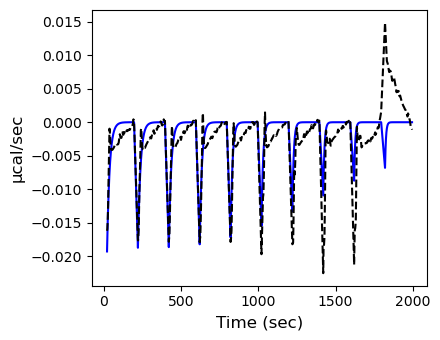

In [23]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].index, df_sim.loc[df_PRDX1.index]["Rate μcal/sec"],"b-", label = "mod sim")
axarr.plot(df_PRDX1.index, df_PRDX1["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fit to Fig 1a top. Sum residual = {sum(residuals)}")
# axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir, "Fit_one_step_e5_koff_heat_vs_time_PRDX1.pdf"),dpi= mpl_dpi)


/tmp/ipykernel_35459/3115953493.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


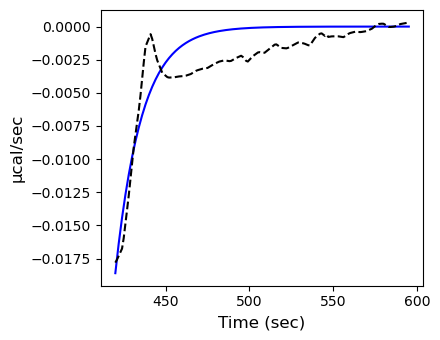

In [24]:
inject_num = 2
injection_interval = 200
# df_PRDX1.loc[(inject_num*180):(inject_num*180+180)].plot()

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].loc[start: end].index, 
           df_sim.loc[df_PRDX1.index].loc[start: end]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.loc[start: end].index, df_PRDX1.loc[start: end]["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fit to Fig 1a top. Sum residual = {sum(residuals)}")
# axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir, "Fit_one_step_e5_koff_peak_heat_vs_time_PRDX1.pdf"),dpi= mpl_dpi)


#### Identifyability

In [25]:
# Save the current session for loading into script
filename = 'session_identi_onestep_e5_koff_Kdapp_PRDX1.pkl'
pickle.dump_session(filename)

# The script that will run
script_identi_onestep_e5_koff_Kdapp_PRDX1 = """
import dill as pickle
filename = 'session_identi_onestep_e5_koff_Kdapp_PRDX1.pkl'
pickle.load_session(filename)

identi_onestep_e5_koff_Kdapp = conf_interval(onestep_e5_koff_Kdapp_Minimizer, 
                  fit_onestep_e5_koff_Kdapp_to_data, 
                  prob=0.95, limits=0.5, log=False, points=21, return_CIclass=True) 

pickle.dump(identi_onestep_e5_koff_Kdapp[1],open("identi_onestep_e5_koff_Kdapp_PRDX1.pkl","wb"))
print("Script completed")
"""

# Write script file
with open(os.path.join(os.getcwd(),"script_identi_onestep_e5_koff_Kdapp_PRDX1.py"), 'w') as f:
    f.write(script_identi_onestep_e5_koff_Kdapp_PRDX1)

In [26]:
identi_onestep_e5_koff_Kdapp = list([0,0])
identi_onestep_e5_koff_Kdapp[1] = pickle.load(open("identi_onestep_e5_koff_Kdapp_PRDX1.pkl","rb"))

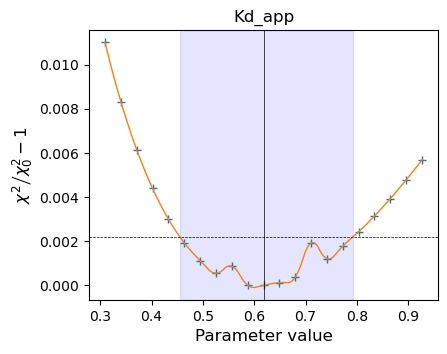

In [27]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)
axarr.set_xlabel('',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(r'',fontsize = mpl_ylabel_fontsize)
identi_onestep_e5_koff_Kdapp[1].plot_ci("Kd_app",ax=axarr)

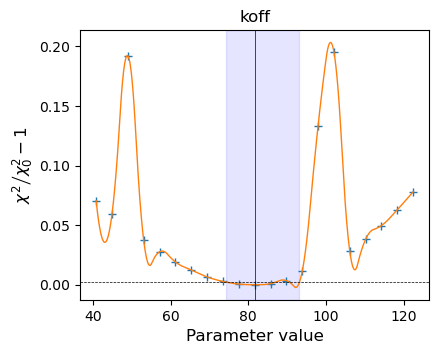

In [28]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)
axarr.set_xlabel('',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(r'',fontsize = mpl_ylabel_fontsize)
identi_onestep_e5_koff_Kdapp[1].plot_ci("koff",ax=axarr)

In [29]:
del identi_onestep_e5_koff_Kdapp
gc.collect()

35137

## Write to file

### Fitted koff and kon

In [30]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_koff_kon.params["koff"].value,
                fit_koff_kon.params["kon"].value,
                fit_koff_kon.params["Kd_app"].value]}
df_fitted_koff_kon_params = pd.DataFrame(data)
df_fitted_koff_kon_params.set_index("Parameter",inplace=True)
df_fitted_koff_kon_params

Value
Parameter           
koff       96.485103
kon        87.713730
Kd_app      1.100000

In [31]:
# Write to file
df_fitted_koff_kon_params.to_csv(os.path.join(os.getcwd(),"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')
df_fitted_koff_kon_params.to_csv(os.path.join(par_dir,"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')


### Fitted Kd, koff and kon

In [32]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_Kd_koff_kon.params["koff"].value,
                fit_Kd_koff_kon.params["kon"].value,
                fit_Kd_koff_kon.params["Kd_app"].value]}
df_fitted_Kd_koff_kon_params = pd.DataFrame(data)
df_fitted_Kd_koff_kon_params.set_index("Parameter",inplace=True)
df_fitted_Kd_koff_kon_params

Value
Parameter            
koff        82.246155
kon        129.859225
Kd_app       0.633349

In [33]:
# Write to file
df_fitted_Kd_koff_kon_params.to_csv(os.path.join(os.getcwd(),"fitted_Kd_koff_kon_PRDX1_params.csv"), 
                                    sep=',', 
                                    encoding='utf-8')
df_fitted_Kd_koff_kon_params.to_csv(os.path.join(par_dir,"fitted_Kd_koff_kon_PRDX1_params.csv"),
                                    sep=',',
                                    encoding='utf-8')
